# Tracking Performance Study with CLD Z Samples

In this notebook we study **tracking performance** using CLD simulation samples
stored as Parquet files.

We will do two main things:

1. **Tracking Efficiency**

   - How often does a reconstructable generated particle (truth) have at least
     one associated reconstructed track?

2. **Tracking Resolution**

   - How well do reconstructed track parameters match their truth values?
   - We will look at:
     - Momentum resolution: Δp and Δp/p
     - Transverse momentum resolution: ΔpT and ΔpT/pT
     - Impact parameter resolution: σ(d₀) vs θ, in p-bins
   - All **separately for different particle types** (μ⁻, e⁻, π⁻), similar in spirit
     to the tracker performance plots in technical design studies.


This is done on **Z samples**, not on single-particle gun events


In [1]:
import sys
import glob
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep


hep.style.use("CMS")



PLOT_DIR = "/eos/user/v/vriecher/mlpf_plots/"
sys.path.append("/eos/user/v/vriecher/mlpf")

from data_generation.preprocessing.utils_data_creation import particle_feature_order, track_feature_order, hit_feature_order

# Directory with your Parquet files (Z sample)
PARQUET_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"

# Collect all Parquet files
parquet_files = sorted(glob.glob(f"{PARQUET_DIR}/*.parquet"))

print(f"Found {len(parquet_files)} parquet files")
print("Example files:", parquet_files[:3])


Found 9935 parquet files
Example files: ['/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05/pf_tree_10.parquet', '/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05/pf_tree_100.parquet', '/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05/pf_tree_1000.parquet']


In [2]:
print("particle_feature_order:")
for i, name in enumerate(particle_feature_order):
    print(f"{i:2d}: {name}")

print("\ntrack_feature_order:")
for i, name in enumerate(track_feature_order):
    print(f"{i:2d}: {name}")
    
print("hit_feature_order:")
for i, name in enumerate(hit_feature_order):
    print(f"{i:2d}: {name}")

# Define convenient indices based on the printed orders
GEN_PDG_IDX    = 0   # PDG
GEN_STATUS_IDX = 1   # generatorStatus
GEN_CHARGE_IDX = 2   # charge
GEN_PT_IDX     = 3   # pt
GEN_ETA_IDX    = 4   # eta
GEN_E_IDX        = 8   # energy
GEN_P_IDX      = 11  # p

TRK_PT_IDX  = 1   # pt
TRK_ETA_IDX = 2   # eta
TRK_P_IDX   = 5   # p
TRK_D0_IDX  = 18  # transverse impact parameter D0
HIT_ET_IDX        = hit_feature_order.index("et")
HIT_ETA_IDX       = hit_feature_order.index("eta")
HIT_E_IDX         = hit_feature_order.index("energy")       # = 5
HIT_SUBDET_IDX    = hit_feature_order.index("subdetector")  # = 10
HIT_TYPE_IDX      = hit_feature_order.index("type")         # = 11

print("\nUsing indices:")
print("GEN  pdg idx :", GEN_PDG_IDX,    "->", particle_feature_order[GEN_PDG_IDX])
print("GEN  status idx:", GEN_STATUS_IDX, "->", particle_feature_order[GEN_STATUS_IDX])
print("GEN  charge idx:", GEN_CHARGE_IDX, "->", particle_feature_order[GEN_CHARGE_IDX])
print("GEN  pt idx :", GEN_PT_IDX,  "->", particle_feature_order[GEN_PT_IDX])
print("GEN  eta idx:", GEN_ETA_IDX, "->", particle_feature_order[GEN_ETA_IDX])
print("GEN  p idx  :", GEN_P_IDX,   "->", particle_feature_order[GEN_P_IDX])
print("TRK  pt idx :", TRK_PT_IDX,  "->", track_feature_order[TRK_PT_IDX])
print("TRK  eta idx:", TRK_ETA_IDX, "->", track_feature_order[TRK_ETA_IDX])
print("TRK  p idx  :", TRK_P_IDX,   "->", track_feature_order[TRK_P_IDX])
print("TRK  D0 idx :", TRK_D0_IDX,  "->", track_feature_order[TRK_D0_IDX])


particle_feature_order:
 0: PDG
 1: generatorStatus
 2: charge
 3: pt
 4: eta
 5: phi
 6: sin_phi
 7: cos_phi
 8: energy
 9: simulatorStatus
10: mass
11: p
12: momentum.x
13: momentum.y
14: momentum.z
15: vertex.x
16: vertex.y
17: vertex.z
18: endpoint.x
19: endpoint.y
20: endpoint.z

track_feature_order:
 0: elemtype
 1: pt
 2: eta
 3: sin_phi
 4: cos_phi
 5: p
 6: px
 7: py
 8: pz
 9: referencePoint.x
10: referencePoint.y
11: referencePoint.z
12: referencePoint_calo.x
13: referencePoint_calo.y
14: referencePoint_calo.z
15: chi2
16: ndf
17: tanLambda
18: D0
19: omega
20: Z0
21: time
22: px_calo
23: py_calo
24: pz_calo
hit_feature_order:
 0: elemtype
 1: et
 2: eta
 3: sin_phi
 4: cos_phi
 5: energy
 6: position.x
 7: position.y
 8: position.z
 9: time
10: subdetector
11: type

Using indices:
GEN  pdg idx : 0 -> PDG
GEN  status idx: 1 -> generatorStatus
GEN  charge idx: 2 -> charge
GEN  pt idx : 3 -> pt
GEN  eta idx: 4 -> eta
GEN  p idx  : 11 -> p
TRK  pt idx : 1 -> pt
TRK  eta idx: 2 

In [3]:
example_file = parquet_files[0]
print("Example file:", example_file)

data_ex = ak.from_parquet(example_file)
print("Fields in example file:", data_ex.fields)

print("X_gen events:", ak.num(data_ex["X_gen"], axis=0))
print("First few event sizes for X_gen:", ak.num(data_ex["X_gen"], axis=1)[:5])
print("First event ygen_track:", ak.to_list(data_ex["ygen_track"][0][:20]))
print("First event X_track:", ak.to_list(data_ex["X_track"][0][:20]))


Example file: /eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05/pf_tree_10.parquet
Fields in example file: ['X_track', 'X_hit', 'X_gen', 'ygen_track', 'ygen_hit', 'ygen_hit_calomother', 'X_pandora', 'pfo_calohit', 'pfo_track']
X_gen events: 100
First few event sizes for X_gen: [40, 22, 48, 15, 37]
First event ygen_track: [4, 3, 6, 9, -1, 0, 2, 4, 25, 2, -1, 11, 28, -1, -1, -1, 5, 10]
First event X_track: [[1.0, 5.595156669616699, 1.6228861808776855, -0.7734050750732422, -0.6339121460914612, 14.729310035705566, -3.54683780670166, -4.327322483062744, 13.625226974487305, 0.0, 0.0, 0.0, -567.0444946289062, -769.5150146484375, 2307.0, 19.65734100341797, 23.0, 2.4351823329925537, 0.2957787811756134, -0.00010716126416809857, -21.71738052368164, -1.0, -3.0855305194854736, -4.66740083694458, 13.625158309936523], [1.0, 2.5505285263061523, -1.7491825819015503, 0.708297848701477, 0.7059136629104614, 7.554429531097412, 1.8004529476165771, 1.8065338134765625, -7.110851764678955,

In [4]:
def compute_tracking_efficiency_simple(
    parquet_dir,
    n_files=100,
    pt_min=0.0,
    eta_max=10,
    primary_r_max=9999,
    primary_z_max=9999,
    pdg_filter=None,
    pt_bins=None,
    eta_bins=None,
):
    """
    tracking efficiency = (# reconstructed gen particles) / (# reconstructable gen particles)
    """
    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))
    files = parquet_files[:n_files]

    num_gen_reco_total = 0
    num_gen_matched_total = 0

    # binned efficency
    result = {}
    if pt_bins is not None:
        pt_bins = np.asarray(pt_bins)
        result["pt_bins"] = pt_bins
        result["pt_num"] = np.zeros(len(pt_bins) - 1, dtype=int)
        result["pt_den"] = np.zeros(len(pt_bins) - 1, dtype=int)
    if eta_bins is not None:
        eta_bins = np.asarray(eta_bins)
        result["eta_bins"] = eta_bins
        result["eta_num"] = np.zeros(len(eta_bins) - 1, dtype=int)
        result["eta_den"] = np.zeros(len(eta_bins) - 1, dtype=int)

    for fn in files:
        data = ak.from_parquet(fn)

        X_gen      = data["X_gen"]
        ygen_track = data["ygen_track"]
        

        for gen_ev, ytrk_ev in zip(X_gen, ygen_track):
            gen = np.asarray(gen_ev)
            y   = np.asarray(ytrk_ev)

            n_gen = len(gen)
            if n_gen == 0:
                continue

            charge = gen[:, GEN_CHARGE_IDX]
            pt     = gen[:, GEN_PT_IDX]
            eta    = gen[:, GEN_ETA_IDX]

            # Primary particles
            status = gen[:, GEN_STATUS_IDX]
            vx = gen[:, 15]
            vy = gen[:, 16]
            vz = gen[:, 17]
            r  = np.sqrt(vx**2 + vy**2)

            is_primary = (status == 1) & (r < primary_r_max) & (np.abs(vz) < primary_z_max)

            # pdg filter
            if pdg_filter is not None:
                pdg = gen[:, GEN_PDG_IDX]
                is_pdg = np.isin(pdg, pdg_filter)
            else:
                is_pdg = np.ones(n_gen, dtype=bool)

            
            # Reconstructable
            reconstructable = (
                (np.abs(charge) > 0) &
                (np.abs(eta) < eta_max) &
                (pt > pt_min) &
                is_primary &
                is_pdg 
                )

            if not np.any(reconstructable):
                continue

            gen_indices = np.arange(n_gen)
            reco_gen_indices = gen_indices[reconstructable]

            # valid Track to Gen indices
            y_valid = (y >= 0) & (y < n_gen)
            matched_gen_all = np.unique(y[y_valid])

            matched_gen = np.intersect1d(matched_gen_all, reco_gen_indices, assume_unique=True)

            num_gen_reco_total    += len(reco_gen_indices)
            num_gen_matched_total += len(matched_gen)

            # binned bookkeeping 
            if pt_bins is not None:
                pt_reco = pt[reconstructable]
                # Denominator: all reconstructable
                idx_pt_den = np.digitize(pt_reco, pt_bins) - 1
                for i in idx_pt_den:
                    if 0 <= i < len(result["pt_den"]):
                        result["pt_den"][i] += 1
                # Numerator: only matched
                mask_matched = np.isin(reco_gen_indices, matched_gen)
                pt_matched = pt_reco[mask_matched]
                idx_pt_num = np.digitize(pt_matched, pt_bins) - 1
                for i in idx_pt_num:
                    if 0 <= i < len(result["pt_num"]):
                        result["pt_num"][i] += 1

            if eta_bins is not None:
                eta_reco = eta[reconstructable]
                idx_eta_den = np.digitize(eta_reco, eta_bins) - 1
                for i in idx_eta_den:
                    if 0 <= i < len(result["eta_den"]):
                        result["eta_den"][i] += 1
                mask_matched = np.isin(reco_gen_indices, matched_gen)
                eta_matched = eta_reco[mask_matched]
                idx_eta_num = np.digitize(eta_matched, eta_bins) - 1
                for i in idx_eta_num:
                    if 0 <= i < len(result["eta_num"]):
                        result["eta_num"][i] += 1

    eff_global = num_gen_matched_total / num_gen_reco_total if num_gen_reco_total > 0 else np.nan

    # binned efficiencies from numerator/denominator
    if "pt_den" in result:
        with np.errstate(divide="ignore", invalid="ignore"):
            result["pt_eff"] = result["pt_num"] / result["pt_den"]
    if "eta_den" in result:
        with np.errstate(divide="ignore", invalid="ignore"):
            result["eta_eff"] = result["eta_num"] / result["eta_den"]

    return eff_global, result


In [5]:
CLD_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"
ARC_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/arc"

pt_bins  = [0.5, 1, 2, 5, 10, 20, 50]
eta_bins = np.linspace(-2.5, 2.5, 11)

eff_cld, res_cld = compute_tracking_efficiency_simple(CLD_DIR, n_files=100,
                                               pt_bins=pt_bins, eta_bins=eta_bins)
eff_arc, res_arc = compute_tracking_efficiency_simple(ARC_DIR, n_files=100,
                                               pt_bins=pt_bins, eta_bins=eta_bins)

print("Globale Effizienz CLD:", eff_cld)
print("Globale Effizienz ARC:", eff_arc)


Globale Effizienz CLD: 0.9197527979625693
Globale Effizienz ARC: 0.8361376471826293


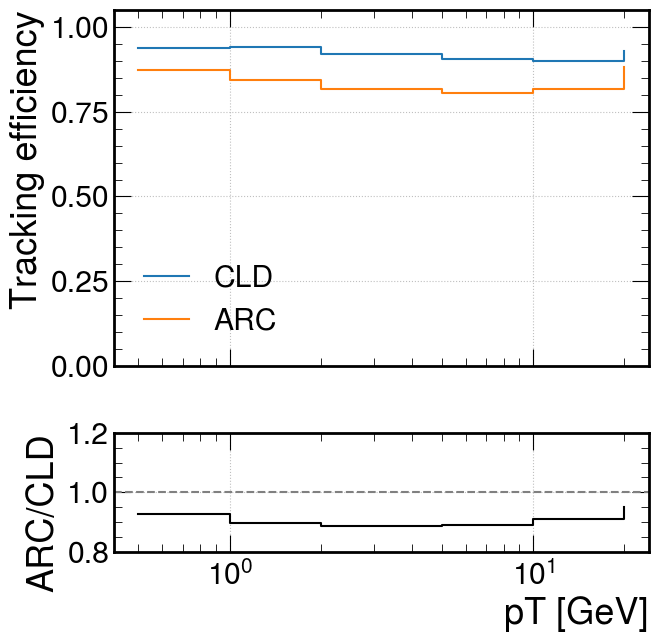

<Figure size 1000x1000 with 0 Axes>

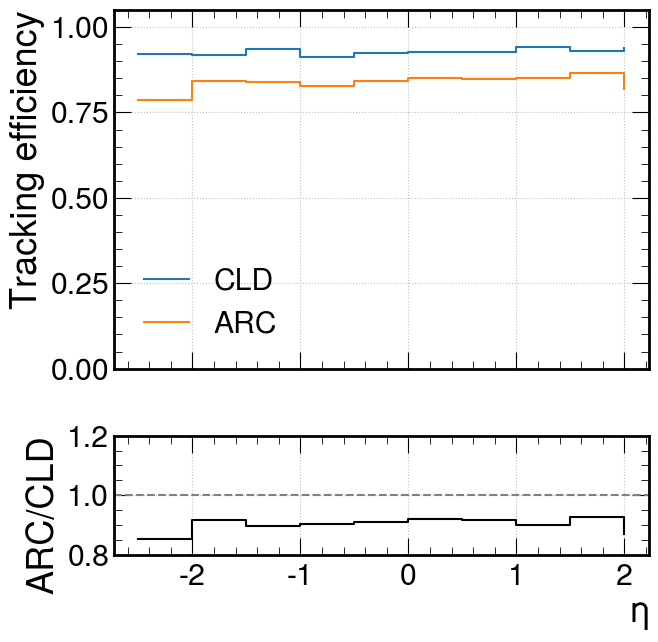

<Figure size 1000x1000 with 0 Axes>

In [6]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(7, 7), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# Top panel: Efficiencies
bin_edges = res_cld["pt_bins"]  # same for CLD + ARC
eff_cld   = res_cld["pt_eff"]
eff_arc   = res_arc["pt_eff"]

ax1.step(bin_edges[:-1], eff_cld, where="post", label="CLD")
ax1.step(bin_edges[:-1], eff_arc, where="post", label="ARC")

ax1.set_xscale("log")
ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Tracking efficiency")
ax1.legend()
ax1.grid(True)

# Bottom panel: Ratio
ratio = eff_arc / eff_cld

ax2.step(bin_edges[:-1], ratio, where="post", color="black")
ax2.axhline(1.0, color="gray", linestyle="--")
ax2.set_xscale("log")
ax2.set_ylim(0.8, 1.2)
ax2.set_xlabel("pT [GeV]")
ax2.set_ylabel("ARC/CLD")
ax2.grid(True)

plt.tight_layout()
plt.show()
plt.savefig(f"{PLOT_DIR}/tracking_efficiency_pt.png")
#Eta bins
eta_edges = res_cld["eta_bins"]      
eta_eff_cld = res_cld["eta_eff"]
eta_eff_arc = res_arc["eta_eff"]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(7, 7), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# Top panel: Efficiency vs eta
ax1.step(eta_edges[:-1], eta_eff_cld, where="post", label="CLD")
ax1.step(eta_edges[:-1], eta_eff_arc, where="post", label="ARC")

ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Tracking efficiency")
ax1.legend()
ax1.grid(True)

#Bottom panel: Ratio 
eta_ratio = eta_eff_arc / eta_eff_cld

ax2.step(eta_edges[:-1], eta_ratio, where="post", color="black")
ax2.axhline(1.0, color="gray", linestyle="--")
ax2.set_ylim(0.8, 1.2)
ax2.set_xlabel(r"$\eta$")
ax2.set_ylabel("ARC/CLD")
ax2.grid(True)

plt.tight_layout()
plt.show()
plt.savefig(f"{PLOT_DIR}/tracking_efficiency_eta.png")

In [7]:

GEN_PDG_IDX    = 0
GEN_STATUS_IDX = 1
GEN_CHARGE_IDX = 2
GEN_PT_IDX     = 3
GEN_ETA_IDX    = 4
GEN_VX_IDX     = 15
GEN_VY_IDX     = 16
GEN_VZ_IDX     = 17

HIT_SUBDET_IDX = 10  # "subdetector" in X_hit


def compute_tracking_efficiency(
    parquet_dir,
    n_files=100,
    pt_min=0.1,              # 100 MeV, TDR-like
    eta_max=10,
    cos_theta_max=0.99,      # |cos(theta)| < 0.99
    primary_r_max=9999,
    primary_z_max=9999,
    pdg_filter=None,
    pt_bins=None,
    theta_bins=None,         # theta-Bins 
    theta_regions=None,      # für pT-Effizienz in theta-Slices
    # optionale Annäherung an "≥ N Hits" für reconstructable:
    use_hit_multiplicity=False,
    min_hits_per_gen=4,
):
    """
    Tracking efficiency ≈ (# reconstructable gen particles mit mindestens einem zugeordneten Track)
                         / (# reconstructable gen particles)

    Rekonstruiert:
      - Ein Gen-Partikel gilt als rekonstruiert, wenn mindestens ein Track existiert,
        dessen ygen_track-Eintrag auf dieses Gen-Partikel zeigt (ygen_track[itk] == igen).
        -> Wir nehmen implizit an, dass die Rekonstruktion selbst eine Purity-Definition
           (ähnlich "≥ 75% Hits") für diese Zuordnung verwendet.

    Reconstructable (TDR-nah, ohne echte Layer-Info):
      - generatorStatus == 1 (stable)
      - geladen (|charge| > 0)
      - pT > pt_min
      - |eta| < eta_max
      - |cos(theta)| < cos_theta_max
      - primary vertex (r < primary_r_max, |z| < primary_z_max)
      - optional PDG-Filter
      - optional (wenn use_hit_multiplicity=True): mindestens min_hits_per_gen Hits,
        basierend auf X_hit und ygen_hit (ohne Unterscheidung nach Layern).

    Binning:
      - pt_bins:         Effizienz vs pT (1D)
      - theta_bins:      Effizienz vs theta (1D)
      - pt,theta 2D:     Effizienz eff_p_theta[ip,it]
      - theta_regions:   pT-Effizienz in vordefinierten theta-Slices
    """
    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))
    files = parquet_files[:n_files]

    num_gen_reco_total    = 0  # reconstructable gen
    num_gen_matched_total = 0  # reconstructable & rekonstruiert

    result = {}

    # --------- pT-Bins ----------
    if pt_bins is not None:
        pt_bins = np.asarray(pt_bins, dtype=float)
        result["pt_bins"] = pt_bins
        n_pt = len(pt_bins) - 1
        result["pt_num"] = np.zeros(n_pt, dtype=int)
        result["pt_den"] = np.zeros(n_pt, dtype=int)
    else:
        n_pt = 0

    # --------- theta-Bins ----------
    if theta_bins is not None:
        theta_bins = np.asarray(theta_bins, dtype=float)
        result["theta_bins"] = theta_bins
        n_th_eff = len(theta_bins) - 1
        result["theta_num"] = np.zeros(n_th_eff, dtype=int)
        result["theta_den"] = np.zeros(n_th_eff, dtype=int)
    else:
        n_th_eff = 0

    # --------- 2D-Bins (p,theta) ----------
    if (pt_bins is not None) and (theta_bins is not None):
        result["num_p_theta"] = np.zeros((n_pt, n_th_eff), dtype=int)
        result["den_p_theta"] = np.zeros((n_pt, n_th_eff), dtype=int)
    else:
        result["num_p_theta"] = None
        result["den_p_theta"] = None

    # --------- theta-Regionen für pT-Effizienz ----------
    if (theta_regions is not None) and (pt_bins is not None):
        theta_regions = np.asarray(theta_regions, dtype=float)  # [[th_min, th_max], ...]
        result["theta_regions"] = theta_regions
        n_regions = len(theta_regions)
        result["pt_num_theta"] = np.zeros((n_regions, n_pt), dtype=int)
        result["pt_den_theta"] = np.zeros((n_regions, n_pt), dtype=int)
    else:
        n_regions = 0

    # ---------------- Loop über Dateien & Events ----------------
    for fn in files:
        data = ak.from_parquet(fn)

        X_gen      = data["X_gen"]
        ygen_track = data["ygen_track"]

        X_hit   = data["X_hit"]      # nur gebraucht, wenn use_hit_multiplicity=True
        ygen_hit = data["ygen_hit"]  # Hit -> Gen-Index

        for gen_ev, ytrk_ev, hits_ev, yhit_ev in zip(X_gen, ygen_track, X_hit, ygen_hit):
            gen = np.asarray(gen_ev)
            y   = np.asarray(ytrk_ev)   # Track -> Gen (oder -1)

            n_gen = len(gen)
            if n_gen == 0:
                continue

            # ---------- Gen-Infos ----------
            charge = gen[:, GEN_CHARGE_IDX]
            pt     = gen[:, GEN_PT_IDX]
            eta    = gen[:, GEN_ETA_IDX]

            theta     = 2.0 * np.arctan(np.exp(-eta))
            theta_deg = np.degrees(theta)
            cos_theta = np.cos(theta)

            status = gen[:, GEN_STATUS_IDX]
            vx = gen[:, GEN_VX_IDX]
            vy = gen[:, GEN_VY_IDX]
            vz = gen[:, GEN_VZ_IDX]
            r  = np.sqrt(vx**2 + vy**2)

            is_primary = (status == 1) & (r < primary_r_max) & (np.abs(vz) < primary_z_max)

            # PDG-Filter (optional)
            if pdg_filter is not None:
                pdg = gen[:, GEN_PDG_IDX]
                is_pdg = np.isin(pdg, pdg_filter)
            else:
                is_pdg = np.ones(n_gen, dtype=bool)

            # ---------- optional: Hit-Multiplicity pro Gen-Teilchen ----------
            if use_hit_multiplicity:
                hits   = np.asarray(hits_ev)
                y_hit  = np.asarray(yhit_ev)   # Hit -> Gen
                nhits_gen = np.zeros(n_gen, dtype=int)

                if len(hits) > 0:
                    # falls du z.B. nur bestimmte subdetector nehmen willst:
                    subdet = hits[:, HIT_SUBDET_IDX].astype(int)
                    # z.B. alle Hits verwenden:
                    mask_hits = (y_hit >= 0) & (y_hit < n_gen)
                    # oder hier könnte man nach subdet filtern, wenn sinnvoll
                    for gidx in y_hit[mask_hits]:
                        nhits_gen[gidx] += 1
                # Falls keine Hits: nhits_gen bleibt 0
            else:
                nhits_gen = None

            # ---------- Reconstructable (TDR-nah, ohne Layer-info) ----------
            reconstructable = (
                (status == 1) &
                (np.abs(charge) > 0) &
                (pt > pt_min) &
                (np.abs(eta) < eta_max) &
                (np.abs(cos_theta) < cos_theta_max) &
                is_primary &
                is_pdg
            )
            if use_hit_multiplicity:
                reconstructable &= (nhits_gen >= min_hits_per_gen)

            if not np.any(reconstructable):
                continue

            gen_indices      = np.arange(n_gen)
            reco_gen_indices = gen_indices[reconstructable]

            # ---------- "rekonstruiert" über ygen_track ----------
            # alle Tracks, die einem Gen-Partikel zugeordnet sind:
            y_valid         = (y >= 0) & (y < n_gen)
            matched_gen_all = np.unique(y[y_valid])
            # Schnitt mit reconstructable:
            matched_gen     = np.intersect1d(matched_gen_all, reco_gen_indices, assume_unique=True)

            num_gen_reco_total    += len(reco_gen_indices)
            num_gen_matched_total += len(matched_gen)

            # praktische Arrays nur für reconstructable
            pt_reco     = pt[reconstructable]
            theta_reco  = theta_deg[reconstructable]
            reco_gen_rc = reco_gen_indices

            mask_matched = np.isin(reco_gen_rc, matched_gen)

            # --------- 1D pT-Effizienz ---------
            if pt_bins is not None:
                idx_pt_den = np.digitize(pt_reco, pt_bins) - 1
                for i in idx_pt_den:
                    if 0 <= i < n_pt:
                        result["pt_den"][i] += 1

                pt_matched = pt_reco[mask_matched]
                idx_pt_num = np.digitize(pt_matched, pt_bins) - 1
                for i in idx_pt_num:
                    if 0 <= i < n_pt:
                        result["pt_num"][i] += 1

            # --------- 1D theta-Effizienz ---------
            if theta_bins is not None:
                idx_th_den = np.digitize(theta_reco, theta_bins) - 1
                for i in idx_th_den:
                    if 0 <= i < n_th_eff:
                        result["theta_den"][i] += 1

                theta_matched = theta_reco[mask_matched]
                idx_th_num = np.digitize(theta_matched, theta_bins) - 1
                for i in idx_th_num:
                    if 0 <= i < n_th_eff:
                        result["theta_num"][i] += 1

            # --------- 2D (p,theta)-Effizienz ---------
            if (pt_bins is not None) and (theta_bins is not None):
                idx_p_all = np.digitize(pt_reco,    pt_bins)    - 1
                idx_t_all = np.digitize(theta_reco, theta_bins) - 1

                valid_den = (
                    (idx_p_all >= 0) & (idx_p_all < n_pt) &
                    (idx_t_all >= 0) & (idx_t_all < n_th_eff)
                )
                for ip, it in zip(idx_p_all[valid_den], idx_t_all[valid_den]):
                    result["den_p_theta"][ip, it] += 1

                idx_p_m = idx_p_all[mask_matched]
                idx_t_m = idx_t_all[mask_matched]
                valid_num = (
                    (idx_p_m >= 0) & (idx_p_m < n_pt) &
                    (idx_t_m >= 0) & (idx_t_m < n_th_eff)
                )
                for ip, it in zip(idx_p_m[valid_num], idx_t_m[valid_num]):
                    result["num_p_theta"][ip, it] += 1

            # --------- pT-Effizienz in theta-Regionen ---------
            if n_regions > 0 and pt_bins is not None:
                for ir, (th_min, th_max) in enumerate(theta_regions):
                    in_region = (theta_reco >= th_min) & (theta_reco < th_max)
                    if not np.any(in_region):
                        continue

                    pt_reg  = pt_reco[in_region]
                    idx_den = np.digitize(pt_reg, pt_bins) - 1
                    for i in idx_den:
                        if 0 <= i < n_pt:
                            result["pt_den_theta"][ir, i] += 1

                    reco_gen_reg   = reco_gen_rc[in_region]
                    matched_reg_m  = np.isin(reco_gen_reg, matched_gen)
                    if not np.any(matched_reg_m):
                        continue
                    pt_reg_matched = pt_reg[matched_reg_m]
                    idx_num = np.digitize(pt_reg_matched, pt_bins) - 1
                    for i in idx_num:
                        if 0 <= i < n_pt:
                            result["pt_num_theta"][ir, i] += 1

    # ---------------- globale Effizienz + Fehler ----------------
    eff_global = num_gen_matched_total / num_gen_reco_total if num_gen_reco_total > 0 else np.nan
    if num_gen_reco_total > 0 and np.isfinite(eff_global):
        eff_global_err = np.sqrt(eff_global * (1.0 - eff_global) / num_gen_reco_total)
    else:
        eff_global_err = np.nan

    result["eff_global"] = eff_global
    result["eff_global_err"] = eff_global_err

    # ---------------- 1D Effizienzen + Fehler ----------------

    # pT
    if pt_bins is not None:
        pt_den = result["pt_den"].astype(float)
        pt_num = result["pt_num"].astype(float)
        with np.errstate(divide="ignore", invalid="ignore"):
            pt_eff = pt_num / pt_den
        pt_err = np.full_like(pt_eff, np.nan, dtype=float)
        mask = pt_den > 0
        pt_err[mask] = np.sqrt(pt_eff[mask] * (1.0 - pt_eff[mask]) / pt_den[mask])
        result["pt_eff"] = pt_eff
        result["pt_err"] = pt_err

    # theta
    if theta_bins is not None:
        th_den = result["theta_den"].astype(float)
        th_num = result["theta_num"].astype(float)
        with np.errstate(divide="ignore", invalid="ignore"):
            th_eff = th_num / th_den
        th_err = np.full_like(th_eff, np.nan, dtype=float)
        mask = th_den > 0
        th_err[mask] = np.sqrt(th_eff[mask] * (1.0 - th_eff[mask]) / th_den[mask])
        result["theta_eff"] = th_eff
        result["theta_err"] = th_err

    # ---------------- 2D Effizienzen (p,theta) + Fehler ----------------
    if (pt_bins is not None) and (theta_bins is not None):
        den_2d = result["den_p_theta"].astype(float)
        num_2d = result["num_p_theta"].astype(float)
        with np.errstate(divide="ignore", invalid="ignore"):
            eff_2d = num_2d / den_2d
        err_2d = np.full_like(eff_2d, np.nan, dtype=float)
        mask = den_2d > 0
        err_2d[mask] = np.sqrt(eff_2d[mask] * (1.0 - eff_2d[mask]) / den_2d[mask])
        result["eff_p_theta"] = eff_2d
        result["err_p_theta"] = err_2d

    # ---------------- pT-Effizienz pro theta-Region ----------------
    if n_regions > 0 and pt_bins is not None:
        den_th = result["pt_den_theta"].astype(float)
        num_th = result["pt_num_theta"].astype(float)
        with np.errstate(divide="ignore", invalid="ignore"):
            pt_eff_theta = num_th / den_th
        pt_err_theta = np.full_like(pt_eff_theta, np.nan, dtype=float)
        mask = den_th > 0
        pt_err_theta[mask] = np.sqrt(
            pt_eff_theta[mask] * (1.0 - pt_eff_theta[mask]) / den_th[mask]
        )
        result["pt_eff_theta"] = pt_eff_theta
        result["pt_err_theta"] = pt_err_theta

    return eff_global, result


In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eff_vs_theta_multi_p_CLD_ARC(
    res_cld,
    res_arc,
    p_bin_indices=None,
    detector_labels=("CLD", "ARC"),
    particle_label=r"\pi^{-}",
    min_entries=30,
    ymin_ratio=0.8,
    ymax_ratio=1.2,
):
    """
    Tracking efficiency vs theta für mehrere p-Bins, für zwei Detektoren (CLD, ARC).

    Pro p-Bin:
      - CLD: durchgezogene Linie, Farbe c_i
      - ARC: gestrichelte Linie, gleiche Farbe c_i
      - Ratio (ARC/CLD): gleiche Farbe c_i
    """

    theta_edges   = res_cld["theta_bins"]
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])

    p_edges = res_cld["pt_bins"]
    n_p  = len(p_edges) - 1
    n_th = len(theta_edges) - 1

    eff_2d_cld = res_cld["eff_p_theta"]   # [n_p, n_th]
    err_2d_cld = res_cld["err_p_theta"]
    den_2d_cld = res_cld["den_p_theta"]

    eff_2d_arc = res_arc["eff_p_theta"]
    err_2d_arc = res_arc["err_p_theta"]
    den_2d_arc = res_arc["den_p_theta"]

    if p_bin_indices is None:
        p_bin_indices = list(range(n_p))

    # Farbzyklus holen
    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(7, 7), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    handles_top = []
    labels_top  = []

    # --- Top: Effizienz vs theta für verschiedene p-Bins ---
    for j, ip in enumerate(p_bin_indices):
        if ip < 0 or ip >= n_p:
            continue

        c = color_cycle[j % len(color_cycle)]

        eff_cld = eff_2d_cld[ip, :]
        err_cld = err_2d_cld[ip, :]
        eff_arc = eff_2d_arc[ip, :]
        err_arc = err_2d_arc[ip, :]

        den_cld = den_2d_cld[ip, :]
        den_arc = den_2d_arc[ip, :]

        good = (den_cld >= min_entries) & (den_arc >= min_entries)

        eff_cld_plot = np.where(good, eff_cld, np.nan)
        err_cld_plot = np.where(good, err_cld, np.nan)
        eff_arc_plot = np.where(good, eff_arc, np.nan)
        err_arc_plot = np.where(good, err_arc, np.nan)

        p_min = p_edges[ip]
        p_max = p_edges[ip+1]
        lab_cld = rf"{detector_labels[0]}, {particle_label}, $p \in [{p_min:.2g},{p_max:.2g}]$ GeV"
        lab_arc = rf"{detector_labels[1]}, {particle_label}, $p \in [{p_min:.2g},{p_max:.2g}]$ GeV"

        hC = ax1.errorbar(
            theta_centers, eff_cld_plot, yerr=err_cld_plot,
            fmt="o-", capsize=3, color=c, label=lab_cld
        )
        hA = ax1.errorbar(
            theta_centers, eff_arc_plot, yerr=err_arc_plot,
            fmt="s--", capsize=3, color=c, label=lab_arc
        )

        handles_top.extend([hC, hA])
        labels_top.extend([lab_cld, lab_arc])

        # --- Bottom: Ratio ARC/CLD für diese p-Bin ---
        ratio = eff_arc / eff_cld
        ratio_err = np.full_like(ratio, np.nan, dtype=float)

        good_ratio = good & (eff_cld > 0) & (eff_arc > 0) & np.isfinite(err_cld) & np.isfinite(err_arc)
        ratio_err[good_ratio] = ratio[good_ratio] * np.sqrt(
            (err_cld[good_ratio] / eff_cld[good_ratio])**2 +
            (err_arc[good_ratio] / eff_arc[good_ratio])**2
        )

        ratio_plot     = np.where(good_ratio, ratio,     np.nan)
        ratio_err_plot = np.where(good_ratio, ratio_err, np.nan)

        ax2.errorbar(
            theta_centers, ratio_plot, yerr=ratio_err_plot,
            fmt="o-", capsize=3, color=c
        )

    ax1.set_ylabel("Tracking efficiency")
    ax1.set_ylim(0.97, 1.01)
    ax1.grid(True, which="both", ls=":", alpha=0.6)
    ax1.set_title(rf"Tracking efficiency vs $\theta$ for {particle_label}")
    ax1.legend(handles_top, labels_top, fontsize=7, ncol=2)

    ax2.axhline(1.0, color="gray", linestyle="--")
    ax2.set_xlabel(r"$\theta$ [deg]")
    ax2.set_ylabel(f"{detector_labels[1]}/{detector_labels[0]}")
    ax2.set_ylim(ymin_ratio, ymax_ratio)
    ax2.grid(True, which="both", ls=":", alpha=0.6)

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{PLOT_DIR}/tracking_efficiency_theta.png")

In [48]:
def plot_eff_vs_pt_multi_theta_CLD_ARC(
    res_cld,
    res_arc,
    theta_region_indices=None,
    detector_labels=("CLD", "ARC"),
    particle_label=r"\pi^{-}",
    min_entries=30,
    logx=True,
    ymin_ratio=0.8,
    ymax_ratio=1.2,
):
    """
    Tracking efficiency vs pT für mehrere theta-Regionen, für zwei Detektoren (CLD, ARC).

    Pro theta-Region:
      - CLD: durchgezogene Linie, Farbe c_i
      - ARC: gestrichelte Linie, gleiche Farbe c_i
      - Ratio (ARC/CLD): gleiche Farbe c_i
    """

    pt_edges   = res_cld["pt_bins"]
    pt_centers = 0.5 * (pt_edges[:-1] + pt_edges[1:])

    theta_regions = res_cld["theta_regions"]
    n_regions = theta_regions.shape[0]
    n_pt      = len(pt_edges) - 1

    eff_th_cld = res_cld["pt_eff_theta"]   # [n_regions, n_pt]
    err_th_cld = res_cld["pt_err_theta"]
    den_th_cld = res_cld["pt_den_theta"]

    eff_th_arc = res_arc["pt_eff_theta"]
    err_th_arc = res_arc["pt_err_theta"]
    den_th_arc = res_arc["pt_den_theta"]

    if theta_region_indices is None:
        theta_region_indices = list(range(n_regions))

    # Farbzyklus holen
    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(7, 7), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    handles_top = []
    labels_top  = []

    # --- Top: Eff vs pT für verschiedene theta-Regionen ---
    for j, ir in enumerate(theta_region_indices):
        if ir < 0 or ir >= n_regions:
            continue

        c = color_cycle[j % len(color_cycle)]

        eff_cld = eff_th_cld[ir, :]
        err_cld = err_th_cld[ir, :]
        eff_arc = eff_th_arc[ir, :]
        err_arc = err_th_arc[ir, :]

        den_cld = den_th_cld[ir, :]
        den_arc = den_th_arc[ir, :]

        good = (den_cld >= min_entries) & (den_arc >= min_entries)

        eff_cld_plot = np.where(good, eff_cld, np.nan)
        err_cld_plot = np.where(good, err_cld, np.nan)
        eff_arc_plot = np.where(good, eff_arc, np.nan)
        err_arc_plot = np.where(good, err_arc, np.nan)

        th_min, th_max = theta_regions[ir]
        lab_cld = rf"{detector_labels[0]}, {particle_label}, $\theta \in [{th_min:.0f}^\circ,{th_max:.0f}^\circ)$"
        lab_arc = rf"{detector_labels[1]}, {particle_label}, $\theta \in [{th_min:.0f}^\circ,{th_max:.0f}^\circ)$"

        hC = ax1.errorbar(
            pt_centers, eff_cld_plot, yerr=err_cld_plot,
            fmt="o-", capsize=3, color=c, label=lab_cld
        )
        hA = ax1.errorbar(
            pt_centers, eff_arc_plot, yerr=err_arc_plot,
            fmt="s--", capsize=3, color=c, label=lab_arc
        )

        handles_top.extend([hC, hA])
        labels_top.extend([lab_cld, lab_arc])

        # --- Bottom: Ratio ARC/CLD ---
        ratio = eff_arc / eff_cld
        ratio_err = np.full_like(ratio, np.nan, dtype=float)

        good_ratio = good & (eff_cld > 0) & (eff_arc > 0) & np.isfinite(err_cld) & np.isfinite(err_arc)
        ratio_err[good_ratio] = ratio[good_ratio] * np.sqrt(
            (err_cld[good_ratio] / eff_cld[good_ratio])**2 +
            (err_arc[good_ratio] / eff_arc[good_ratio])**2
        )

        ratio_plot     = np.where(good_ratio, ratio,     np.nan)
        ratio_err_plot = np.where(good_ratio, ratio_err, np.nan)

        ax2.errorbar(
            pt_centers, ratio_plot, yerr=ratio_err_plot,
            fmt="o-", capsize=3, color=c
        )

    if logx:
        ax1.set_xscale("log")
        ax2.set_xscale("log")

    ax1.set_ylabel("Tracking efficiency")
    ax1.set_ylim(0.96, 1.02)
    ax1.grid(True, which="both", ls=":", alpha=0.6)
    ax1.set_title(rf"Tracking efficiency vs $p_T$ for {particle_label}")
    ax1.legend(handles_top, labels_top, fontsize=7, ncol=2)

    ax2.axhline(1.0, color="gray", linestyle="--")
    ax2.set_xlabel(r"$p_T$ [GeV]")
    ax2.set_ylabel(f"{detector_labels[1]}/{detector_labels[0]}")
    ax2.set_ylim(ymin_ratio, ymax_ratio)
    ax2.grid(True, which="both", ls=":", alpha=0.6)

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{PLOT_DIR}/tracking_efficiency_pt_theta.png")

In [66]:
pt_bins = np.logspace(-1, 2, 10)
theta_bins = np.linspace(10, 170, 16)

eff_cld, res_cld = compute_tracking_efficiency(
    CLD_DIR, n_files=1000,
    pt_bins=pt_bins,
    pt_min=1,
    primary_r_max=50,
    primary_z_max=50,
    theta_bins=theta_bins,
    pdg_filter=[-211],  # pi-
    use_hit_multiplicity=True,
    min_hits_per_gen=4
)

eff_arc, res_arc = compute_tracking_efficiency(
    ARC_DIR, n_files=1000,
    pt_bins=pt_bins,
    pt_min=1,
    primary_r_max=50,
    primary_z_max=50,
    theta_bins=theta_bins,
    pdg_filter=[-211],
    use_hit_multiplicity=True,
    min_hits_per_gen=4
)

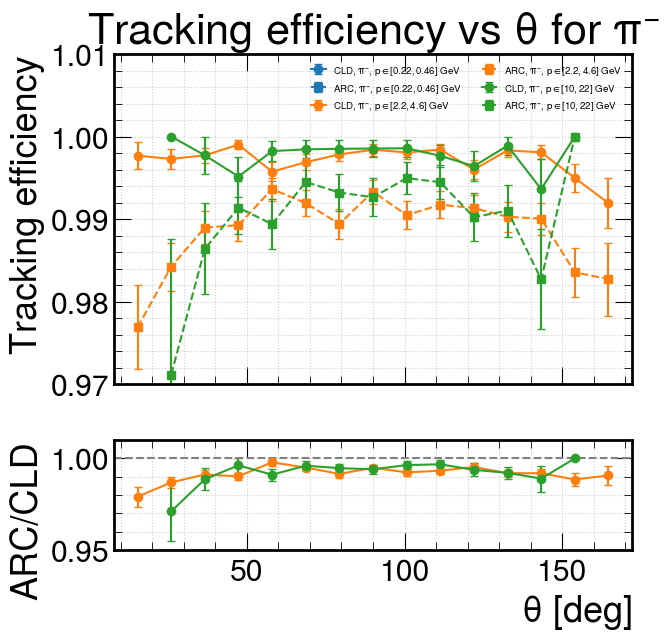

<Figure size 1000x1000 with 0 Axes>

In [71]:

plot_eff_vs_theta_multi_p_CLD_ARC(
    res_cld,
    res_arc,
    p_bin_indices=[1,4,6],  # z.B. drei p-Bins
    particle_label=r"$\pi^{-}$",
    ymin_ratio=0.95,
    ymax_ratio=1.01
)

Break! Hier jetzt eine verallgemeinerte Resolution Function

In [12]:
import glob
import numpy as np
import awkward as ak
from scipy.optimize import curve_fit

# ---- Indizes ----
GEN_PDG_IDX    = 0
GEN_STATUS_IDX = 1
GEN_CHARGE_IDX = 2
GEN_PT_IDX     = 3
GEN_ETA_IDX    = 4
GEN_P_IDX      = 11
GEN_VX_IDX     = 15
GEN_VY_IDX     = 16
GEN_VZ_IDX     = 17

TRK_PT_IDX     = 1
TRK_ETA_IDX    = 2
TRK_D0_IDX     = 18


def _gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def _fit_gaussian_3sigma_clipped_fast(residuals, min_entries=40):
    """
    Beschleunigte & robustere Version:
      - robuste Startschätzung über Median & 16/84-Perzentile
      - 3σ-Clipping um 0 (wie im Paper)
      - adaptives Histogram (nicht fix 60 Bins)
    """
    residuals = np.asarray(residuals, dtype=float)
    n = residuals.size
    if n < min_entries:
        return np.nan, np.nan

    # robuste σ-Schätzung über 16/84-Perzentile
    m0 = np.median(residuals)
    q16, q84 = np.percentile(residuals, [16, 84])
    sig0 = 0.5 * (q84 - q16)
    if not np.isfinite(sig0) or sig0 <= 0:
        return np.nan, np.nan

    # 3σ-Clipping um 0 (wie in der Note beschrieben)
    mask = np.abs(residuals - 0.0) < 3.0 * sig0
    res_clipped = residuals[mask]
    n_clip = res_clipped.size
    if n_clip < min_entries:
        return np.nan, np.nan

    # adaptives Histogram: grob 5–20 Einträge pro Bin
    n_hist_bins = max(10, min(40, n_clip // 5))
    counts, edges = np.histogram(res_clipped, bins=n_hist_bins)
    xcenters = 0.5 * (edges[:-1] + edges[1:])

    mnonzero = counts > 0
    if np.count_nonzero(mnonzero) < 5:
        return np.nan, np.nan

    x_fit = xcenters[mnonzero]
    y_fit = counts[mnonzero]

    # Startwerte aus den geklippten Daten
    A0 = y_fit.max()
    mu0 = 0.0
    sig0 = np.std(res_clipped)
    if not np.isfinite(sig0) or sig0 <= 0:
        return np.nan, np.nan

    try:
        popt, pcov = curve_fit(
            _gauss,
            x_fit,
            y_fit,
            p0=[A0, mu0, sig0],
            maxfev=5000,
        )
        A_fit, mu_fit, sig_fit = popt
        if not np.isfinite(sig_fit) or sig_fit <= 0:
            return np.nan, np.nan
        return sig_fit, mu_fit
    except Exception:
        return np.nan, np.nan


def compute_track_resolution_p_theta_fit(
    parquet_dir,
    n_files=100,
    pt_min=0.1,
    eta_max=10,
    cos_theta_max=0.99,
    primary_r_max=9999,
    primary_z_max=9999,
    pdg_filter=None,
    p_bins=None,         # Bins in |p| [GeV]
    theta_bins=None,     # Bins in theta [deg]
    min_entries=50,      # mind. N Residuen pro Bin für Fit
    observable="d0",     # "d0" oder "pt"
):
    """
    Allgemeine Funktion für Tracking-Resolution in (p, theta)-Bins.

    observable:
      - "d0":
          Residuum R = d0_reco (für primäre Tracks, d0_true ~ 0)
          → σ(R) = σ(d0)
      - "pt":
          Residuum R = (pT_true - pT_reco) / pT_true**2   [GeV^-1]
          → σ(R), entspricht TDR-Definition für 1/pT-Resolution

    Rückgabe: dict mit
      - "p_bins", "theta_bins"
      - "sigma":     [n_p, n_th]  (σ aus Fit)
      - "mu":        [n_p, n_th]  (mean aus Fit)
      - "n_entries": [n_p, n_th]
      - "observable", "residual_note"
      - Alias-Keys:
          * bei observable=="d0": "sigma_d0", "mu_d0"
          * bei observable=="pt": "sigma_R",  "mu_R"
    """
    if p_bins is None or theta_bins is None:
        raise ValueError("Bitte p_bins und theta_bins angeben!")

    if observable not in ("d0", "pt"):
        raise ValueError(f"observable muss 'd0' oder 'pt' sein, nicht {observable!r}")

    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))
    files = parquet_files[:n_files]

    p_bins    = np.asarray(p_bins, dtype=float)
    theta_bins = np.asarray(theta_bins, dtype=float)

    n_p  = len(p_bins) - 1
    n_th = len(theta_bins) - 1
    n_bins = n_p * n_th

    residuals_bins = [[] for _ in range(n_bins)]

    for fn in files:
        data = ak.from_parquet(fn)

        X_gen      = data["X_gen"]
        X_track    = data["X_track"]
        ygen_track = data["ygen_track"]

        for gen_ev, trk_ev, ytrk_ev in zip(X_gen, X_track, ygen_track):
            gen = np.asarray(gen_ev)
            trk = np.asarray(trk_ev)
            y   = np.asarray(ytrk_ev)

            n_gen = len(gen)
            n_trk = len(trk)
            if n_gen == 0 or n_trk == 0:
                continue

            # --- Gen-Infos ---
            charge  = gen[:, GEN_CHARGE_IDX]
            pt_gen  = gen[:, GEN_PT_IDX]
            eta_gen = gen[:, GEN_ETA_IDX]

            theta     = 2.0 * np.arctan(np.exp(-eta_gen))
            theta_deg = np.degrees(theta)
            cos_theta = np.cos(theta)

            status = gen[:, GEN_STATUS_IDX]
            vx = gen[:, GEN_VX_IDX]
            vy = gen[:, GEN_VY_IDX]
            vz = gen[:, GEN_VZ_IDX]
            r  = np.sqrt(vx**2 + vy**2)

            is_primary = (status == 1) & (r < primary_r_max) & (np.abs(vz) < primary_z_max)

            if pdg_filter is not None:
                pdg = gen[:, GEN_PDG_IDX]
                is_pdg = np.isin(pdg, pdg_filter)
            else:
                is_pdg = np.ones(n_gen, dtype=bool)

            reconstructable = (
                (status == 1) &
                (np.abs(charge) > 0) &
                (pt_gen > pt_min) &
                (np.abs(eta_gen) < eta_max) &
                (np.abs(cos_theta) < cos_theta_max) &
                is_primary &
                is_pdg
            )

            # --- alle gematchten Tracks auf einmal ---
            y_valid = (y >= 0) & (y < n_gen)
            if not np.any(y_valid):
                continue

            igen_all = y[y_valid]
            trk_sel  = trk[y_valid, :]

            mask_reco = reconstructable[igen_all]
            if not np.any(mask_reco):
                continue

            igen_sel = igen_all[mask_reco]
            trk_sel  = trk_sel[mask_reco, :]

            # true p, true theta
            p_true      = gen[igen_sel, GEN_P_IDX]
            th_true_deg = theta_deg[igen_sel]

            # Residuen je nach observable
            if observable == "d0":
                residual_all = trk_sel[:, TRK_D0_IDX]

            elif observable == "pt":
                pt_true_sel = pt_gen[igen_sel]
                pt_reco_sel = trk_sel[:, TRK_PT_IDX]

                valid_pt = pt_true_sel > 0
                if not np.any(valid_pt):
                    continue

                p_true      = p_true[valid_pt]
                th_true_deg = th_true_deg[valid_pt]
                pt_true_sel = pt_true_sel[valid_pt]
                pt_reco_sel = pt_reco_sel[valid_pt]

                residual_all = (pt_true_sel - pt_reco_sel) / (pt_true_sel**2)

            # Bin-Indices
            ip  = np.digitize(p_true,      p_bins)     - 1
            ith = np.digitize(th_true_deg, theta_bins) - 1

            valid_bins = (
                (ip  >= 0) & (ip  < n_p) &
                (ith >= 0) & (ith < n_th)
            )
            if not np.any(valid_bins):
                continue

            ip        = ip[valid_bins]
            ith       = ith[valid_bins]
            residuals = residual_all[valid_bins]

            flat_idx = ip * n_th + ith

            for b in np.unique(flat_idx):
                mask_b = (flat_idx == b)
                if np.any(mask_b):
                    residuals_bins[b].extend(residuals[mask_b])

    # ---- Fit in jedem Bin ----
    sigma  = np.full((n_p, n_th), np.nan, dtype=float)
    mu     = np.full((n_p, n_th), np.nan, dtype=float)
    n_entries = np.zeros((n_p, n_th), dtype=int)

    for ip in range(n_p):
        for ith in range(n_th):
            flat = ip * n_th + ith
            res_list = np.array(residuals_bins[flat], dtype=float)
            n = res_list.size
            n_entries[ip, ith] = n
            if n < min_entries:
                continue

            sig_fit, mu_fit = _fit_gaussian_3sigma_clipped_fast(
                res_list,
                min_entries=min_entries
            )
            sigma[ip, ith] = sig_fit
            mu[ip, ith]    = mu_fit

    if observable == "d0":
        residual_note = "R = d0_reco (d0_true ~ 0 für primäre Tracks)"
    else:
        residual_note = "R = (pT_true - pT_reco) / pT_true**2  [GeV^-1]"

    result = {
        "p_bins": p_bins,
        "theta_bins": theta_bins,
        "sigma": sigma,
        "mu": mu,
        "n_entries": n_entries,
        "observable": observable,
        "residual_note": residual_note,
    }

    # Alias-Keys für Kompatibilität / Klarheit
    if observable == "d0":
        result["sigma_d0"] = sigma
        result["mu_d0"]    = mu
    elif observable == "pt":
        result["sigma_R"] = sigma
        result["mu_R"]    = mu

    return result


In [13]:
def plot_track_res_vs_theta_multi_p_CLD_ARC(
    res_cld,
    res_arc,
    p_bin_indices=None,
    detector_labels=("CLD", "ARC"),
    particle_label=r"\pi^{-}",
    ymin_ratio=0.5,
    ymax_ratio=1.5,
    min_entries=50,
    yscale="log",
    observable=None,
):
    """
    Plot resolution vs theta for multiple p-bins for CLD & ARC,
    including error bars and ratio uncertainties.
    """

    # --- Observable bestimmen ---
    if observable is None:
        observable = res_cld.get("observable", "d0")

    if observable not in ("d0", "pt"):
        raise ValueError("observable must be 'd0' or 'pt'")

    # --- Bins ---
    theta_edges   = res_cld["theta_bins"]
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])

    p_edges = res_cld["p_bins"]
    n_p  = len(p_edges) - 1
    n_th = len(theta_edges) - 1

    # --- Sigma Arrays ---
    if observable == "d0":
        sigC = res_cld.get("sigma_d0", res_cld["sigma"])
        sigA = res_arc.get("sigma_d0", res_arc["sigma"])

        # ACHSENBESCHRIFTUNG KORRIGIERT:
        y_label = r"$\sigma(\Delta d_0)$"

        title = rf"Tracking resolution for ${particle_label}$"

    else:  # pt resolution (σ(ΔpT/pT²)) = σ(1/pT)
        sigC = res_cld.get("sigma_R", res_cld["sigma"])
        sigA = res_arc.get("sigma_R", res_arc["sigma"])

        # ACHSENBESCHRIFTUNG KORRIGIERT:
        y_label = r"$\sigma\!\left(\frac{\Delta p_T}{p_{T,\mathrm{true}}^2}\right)$ [GeV$^{-1}$]"

        title = rf"Tracking resolution for ${particle_label}$"

    # Entries
    nC = res_cld["n_entries"]
    nA = res_arc["n_entries"]

    if p_bin_indices is None:
        p_bin_indices = list(range(n_p))

    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(7, 7), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    handles_top = []
    labels_top  = []

    for j, ip in enumerate(p_bin_indices):
        if not (0 <= ip < n_p):
            continue

        c = color_cycle[j % len(color_cycle)]

        sC = sigC[ip, :]
        sA = sigA[ip, :]
        cC = nC[ip, :]
        cA = nA[ip, :]

        # gültige Zellen
        good = (
            (cC >= min_entries) &
            (cA >= min_entries) &
            np.isfinite(sC) & np.isfinite(sA)
        )

        # Fehler auf sigma
        sigC_err = np.where(
            good, sC / np.sqrt(2 * np.maximum(cC - 1, 1)), np.nan
        )
        sigA_err = np.where(
            good, sA / np.sqrt(2 * np.maximum(cA - 1, 1)), np.nan
        )

        # Oberes Panel
        hC = ax1.errorbar(theta_centers, sC, yerr=sigC_err,
                           fmt="o-", color=c)
        hA = ax1.errorbar(theta_centers, sA, yerr=sigA_err,
                           fmt="s--", color=c)

        p_min = p_edges[ip]
        p_max = p_edges[ip+1]

        handles_top.extend([hC.lines[0], hA.lines[0]])
        labels_top.extend([
            rf"{detector_labels[0]}, $p\in[{p_min:.1f},{p_max:.1f}]$ GeV",
            rf"{detector_labels[1]}, $p\in[{p_min:.1f},{p_max:.1f}]$ GeV",
        ])

        # Ratio
        ratio = sA / sC
        ratio_err = ratio * np.sqrt(
            (sigA_err / sA)**2 + (sigC_err / sC)**2
        )

        ax2.errorbar(theta_centers, ratio, yerr=ratio_err,
                     fmt="o-", color=c)

    # Styling oben
    ax1.set_ylabel(y_label)
    ax1.set_yscale(yscale)
    ax1.grid(True, ls=":", alpha=0.6)
    ax1.set_title(title)
    ax1.legend(handles_top, labels_top, fontsize=7, ncol=2)

    # Styling unten
    ax2.axhline(1.0, color="gray", ls="--", lw=1)
    ax2.set_xlabel(r"$\theta$ [deg]")
    ax2.set_ylabel(f"{detector_labels[1]}/{detector_labels[0]}")
    ax2.set_ylim(ymin_ratio, ymax_ratio)
    ax2.grid(True, ls=":", alpha=0.6)

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{PLOT_DIR}/tracking_resolution_theta.png")


In [14]:
def plot_track_res_vs_p_multi_theta_CLD_ARC(
    res_cld,
    res_arc,
    theta_bin_indices=None,
    detector_labels=("CLD", "ARC"),
    particle_label=r"\pi^{-}",
    ymin_ratio=0.5,
    ymax_ratio=1.5,
    min_entries=50,
    yscale="log",
    observable=None,
):
    """
    Plot tracking resolution vs p for multiple theta bins for CLD & ARC,
    including error bars and ratio uncertainties.
    """

    # --- Observable bestimmen ---
    if observable is None:
        observable = res_cld.get("observable", "d0")

    if observable not in ("d0", "pt"):
        raise ValueError("observable must be 'd0' or 'pt'")

    # --- Binning ---
    p_edges   = res_cld["p_bins"]
    p_centers = 0.5 * (p_edges[:-1] + p_edges[1:])

    theta_edges = res_cld["theta_bins"]
    n_p  = len(p_edges) - 1
    n_th = len(theta_edges) - 1

    # --- Resolution Arrays ---
    if observable == "d0":
        sigC = res_cld.get("sigma_d0", res_cld["sigma"])
        sigA = res_arc.get("sigma_d0", res_arc["sigma"])

        y_label = r"$\sigma(\Delta d_0)$"
        title   = rf"Tracking resolution for ${particle_label}$"

    else:  # pt resolution
        sigC = res_cld.get("sigma_R", res_cld["sigma"])
        sigA = res_arc.get("sigma_R", res_arc["sigma"])

        y_label = r"$\sigma\!\left(\frac{\Delta p_T}{p_{T,\mathrm{true}}^2}\right)$ [GeV$^{-1}$]"
        title   = rf"Tracking resolution for ${particle_label}$"

    # Entries
    nC = res_cld["n_entries"]
    nA = res_arc["n_entries"]

    # Default: alle theta-Bins
    if theta_bin_indices is None:
        theta_bin_indices = list(range(n_th))

    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(7, 7), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    handles_top = []
    labels_top  = []

    for j, ith in enumerate(theta_bin_indices):
        if not (0 <= ith < n_th):
            continue

        c = color_cycle[j % len(color_cycle)]

        sC = sigC[:, ith]  # resolution CLD for this theta-bin
        sA = sigA[:, ith]
        cC = nC[:, ith]    # entries
        cA = nA[:, ith]

        # gültige Zellen
        good = (
            (cC >= min_entries) &
            (cA >= min_entries) &
            np.isfinite(sC) & np.isfinite(sA)
        )

        # Fehler auf sigma
        sigC_err = np.where(
            good, sC / np.sqrt(2 * np.maximum(cC - 1, 1)), np.nan
        )
        sigA_err = np.where(
            good, sA / np.sqrt(2 * np.maximum(cA - 1, 1)), np.nan
        )

        # --- Oberes Panel ---
        hC = ax1.errorbar(
            p_centers, sC, yerr=sigC_err,
            fmt="o-", color=c
        )
        hA = ax1.errorbar(
            p_centers, sA, yerr=sigA_err,
            fmt="s--", color=c
        )

        th_min = theta_edges[ith]
        th_max = theta_edges[ith+1]

        handles_top.extend([hC.lines[0], hA.lines[0]])
        labels_top.extend([
            rf"{detector_labels[0]}, $\theta\in[{th_min:.0f}^\circ,{th_max:.0f}^\circ]$",
            rf"{detector_labels[1]}, $\theta\in[{th_min:.0f}^\circ,{th_max:.0f}^\circ]$",
        ])

        # --- Ratio ---
        ratio = sA / sC
        ratio_err = ratio * np.sqrt(
            (sigA_err / sA)**2 + (sigC_err / sC)**2
        )

        ax2.errorbar(
            p_centers, ratio, yerr=ratio_err,
            fmt="o-", color=c
        )

    # Styling oben
    ax1.set_ylabel(y_label)
    ax1.set_yscale(yscale)
    ax1.grid(True, ls=":", alpha=0.6)
    ax1.set_title(title)
    ax1.legend(handles_top, labels_top, fontsize=7, ncol=2)

    # Styling unten
    ax2.axhline(1.0, color="gray", ls="--", lw=1)
    ax2.set_xlabel(r"$p$ [GeV]")
    ax2.set_ylabel(f"{detector_labels[1]}/{detector_labels[0]}")
    ax2.set_ylim(ymin_ratio, ymax_ratio)
    ax2.grid(True, ls=":", alpha=0.6)

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{PLOT_DIR}/tracking_resolution_p.png")


In [15]:
CLD_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"
ARC_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/arc"

p_bins    = np.logspace(0, np.log10(15), 8)       # von 1 bis 15 GeV 
theta_bins = np.linspace(20, 160, 16)   


res_d0_cld = compute_track_resolution_p_theta_fit(
    CLD_DIR,
    n_files=1000,
    pt_min=1.0,
    primary_r_max=50,   # mm
    primary_z_max=50,   # mm
    p_bins=p_bins,
    theta_bins=theta_bins,
    pdg_filter=[-211],  # pi-
    min_entries=50,
    observable="d0",
)

res_d0_arc = compute_track_resolution_p_theta_fit(
    ARC_DIR,
    n_files=1000,
    pt_min=1.0,
    primary_r_max=50,
    primary_z_max=50,
    p_bins=p_bins,
    theta_bins=theta_bins,
    pdg_filter=[-211],
    min_entries=50,
    observable="d0",
)
res_pt_cld = compute_track_resolution_p_theta_fit(
    CLD_DIR,
    n_files=1000,
    pt_min=1.0,
    primary_r_max=50,
    primary_z_max=50,
    p_bins=p_bins,
    theta_bins=theta_bins,
    pdg_filter=[-211],
    min_entries=50,
    observable="pt",
)
res_pt_arc = compute_track_resolution_p_theta_fit(
    ARC_DIR,
    n_files=1000,
    pt_min=1.0,
    primary_r_max=50,
    primary_z_max=50,
    p_bins=p_bins,
    theta_bins=theta_bins,
    pdg_filter=[-211],
    min_entries=50,
    observable="pt",
)


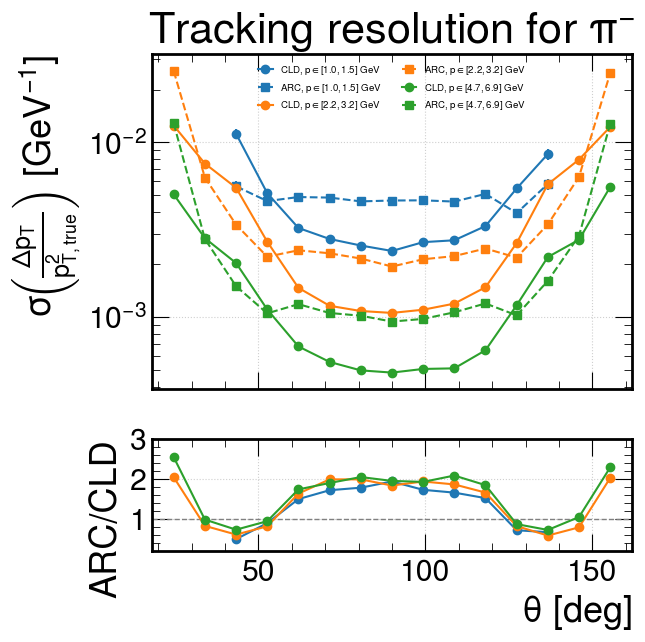

<Figure size 1000x1000 with 0 Axes>

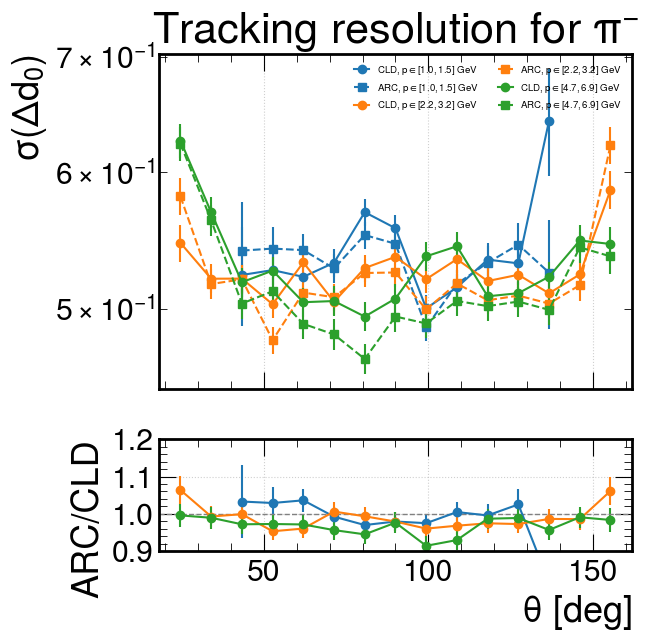

<Figure size 1000x1000 with 0 Axes>

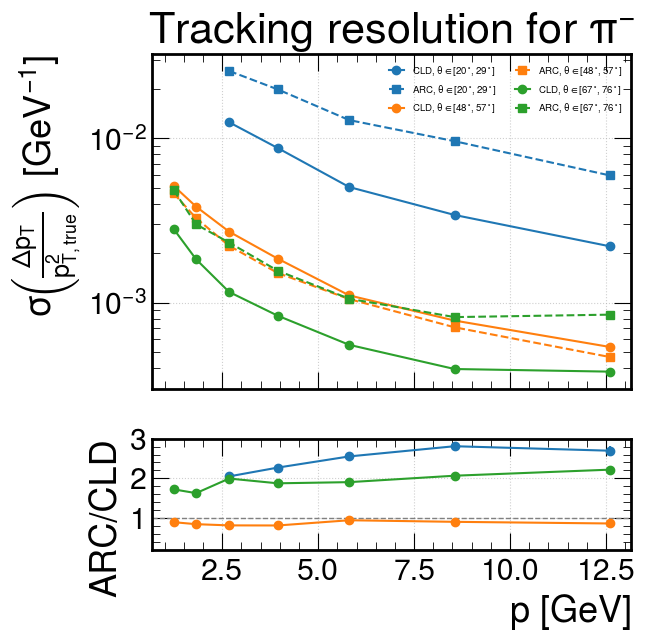

<Figure size 1000x1000 with 0 Axes>

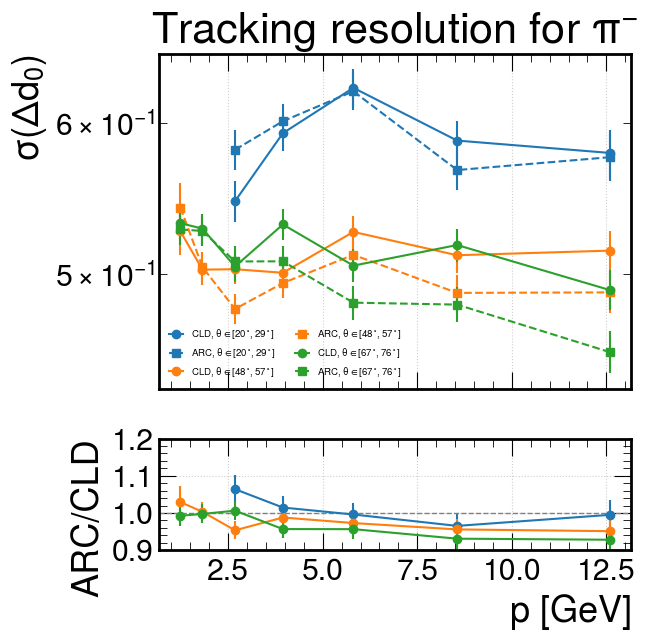

<Figure size 1000x1000 with 0 Axes>

In [65]:
plot_track_res_vs_theta_multi_p_CLD_ARC(
    res_pt_cld,
    res_pt_arc,
    p_bin_indices=[0,2, 4 ],
    particle_label=r"\pi^{-}",
    ymin_ratio=0.2,
    ymax_ratio=3,
    min_entries=50,
    observable="pt",  # könnte man auch weglassen, wird erkannt
)
plot_track_res_vs_theta_multi_p_CLD_ARC(
    res_d0_cld,
    res_d0_arc,
    p_bin_indices=[0,2, 4  ],
    particle_label=r"\pi^{-}",
    ymin_ratio=0.9,
    ymax_ratio=1.2,
    min_entries=50,
    observable="d0",  # könnte man auch weglassen, wird erkannt
)

plot_track_res_vs_p_multi_theta_CLD_ARC(
    res_pt_cld,
    res_pt_arc,
    theta_bin_indices=[0,3,5],
    particle_label=r"\pi^{-}",
    ymin_ratio=0.2,
    ymax_ratio=3,
    min_entries=50,
    observable="pt",  # könnte man auch weglassen, wird erkannt
)
plot_track_res_vs_p_multi_theta_CLD_ARC(
    res_d0_cld,
    res_d0_arc,
    theta_bin_indices=[0,3,5],
    particle_label=r"\pi^{-}",
    ymin_ratio=0.9,
    ymax_ratio=1.2,
    min_entries=50,
    observable="d0",  # könnte man auch weglassen, wird erkannt
) 


In [17]:
def compute_event_energy_resolution_binned_fixed_width(
    parquet_dir,
    n_files=100,
    bin_width=5.0,            # bin width in GeV (only used if E_true_bins=None)
    exclude_neutrinos=True,
    exclude_muons_in_true=False,  # Default = include muons in E_true
    allowed_subdets=None,     # e.g. [1,2] for ECAL+HCAL
    min_entries_fit=40,
    E_true_bins=None,         # predefined E_true bin edges; if None, auto from sample
):
    """
    Event-based calorimeter energy response and resolution in fixed-width E_true bins.

    E_true (visible energy):
      - sum of energies of all stable (status==1) particles
      - optionally excluding neutrinos (12,14,16)
      - optionally excluding muons (if exclude_muons_in_true=True)
      - no eta/theta cuts

    E_reco:
      - sum of energies of calorimeter hits (X_hit)
      - optionally restricted to given subdetectors

    Returns:
      - binned response (mean_ratio)
      - binned resolution (sigma)
      - event-level arrays: E_true_events, E_reco_events
    """

    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))
    files = parquet_files[:n_files]

    # -----------------------------
    # 1) collect all E_true values for binning
    # -----------------------------
    E_true_list = []

    for fn in files:
        data = ak.from_parquet(fn)
        X_gen = data["X_gen"]

        for gen_ev in X_gen:
            gen = np.asarray(gen_ev)
            if gen.size == 0:
                continue

            status = gen[:, GEN_STATUS_IDX]
            pdg    = gen[:, GEN_PDG_IDX]

            is_vis = (status == 1)
            if exclude_neutrinos:
                is_vis &= ~np.isin(np.abs(pdg), [12, 14, 16])
            if exclude_muons_in_true:
                is_vis &= ~(np.abs(pdg) == 13)

            if not np.any(is_vis):
                continue

            E_true = gen[is_vis, GEN_E_IDX].sum()
            if E_true > 0:
                E_true_list.append(E_true)

    if len(E_true_list) == 0:
        raise RuntimeError("No valid E_true values found.")

    E_true_arr = np.array(E_true_list)

    # -----------------------------
    # 2) define binning
    # -----------------------------
    if E_true_bins is None:
        # hartes unteres Limit (optional)
        E_min = 75
        E_max = np.max(E_true_arr)
        n_bins = int(np.ceil((E_max - E_min) / bin_width))
        E_true_bins = E_min + np.arange(n_bins + 1) * bin_width
    else:
        E_true_bins = np.asarray(E_true_bins, float)
        if E_true_bins.ndim != 1 or E_true_bins.size < 2:
            raise ValueError("E_true_bins must be 1D array with >=2 edges.")

    E_min = E_true_bins[0]
    E_max = E_true_bins[-1]
    n_bins = len(E_true_bins) - 1
    E_centers = 0.5 * (E_true_bins[:-1] + E_true_bins[1:])

    residuals_bins = [[] for _ in range(n_bins)]

    # NEW: store event-level values
    E_true_events = []
    E_reco_events = []

    # -----------------------------
    # 3) compute E_reco, fill bins
    # -----------------------------
    for fn in files:
        data = ak.from_parquet(fn)

        X_gen = data["X_gen"]
        X_hit = data["X_hit"]

        for gen_ev, hits_ev in zip(X_gen, X_hit):

            gen  = np.asarray(gen_ev)
            hits = np.asarray(hits_ev)

            if gen.size == 0:
                continue

            status = gen[:, GEN_STATUS_IDX]
            pdg    = gen[:, GEN_PDG_IDX]

            is_vis = (status == 1)
            if exclude_neutrinos:
                is_vis &= ~np.isin(np.abs(pdg), [12, 14, 16])
            if exclude_muons_in_true:
                is_vis &= ~(np.abs(pdg) == 13)

            if not np.any(is_vis):
                continue

            E_true = gen[is_vis, GEN_E_IDX].sum()
            if E_true <= 0:
                continue

            if not (E_min <= E_true <= E_max):
                continue

            if hits.size == 0:
                continue

            E_hits = hits[:, HIT_E_IDX]
            if allowed_subdets is not None:
                subdet = hits[:, HIT_SUBDET_IDX].astype(int)
                mask = np.isin(subdet, allowed_subdets)
                E_hits = E_hits[mask]

            E_reco = E_hits.sum()

            # store event-level values (new!)
            E_true_events.append(E_true)
            E_reco_events.append(E_reco)

            R = (E_reco - E_true) / E_true

            idx = np.digitize(E_true, E_true_bins) - 1
            if 0 <= idx < n_bins:
                residuals_bins[idx].append(R)

    # -----------------------------
    # 4) fit per bin + response stats
    # -----------------------------
    sigma      = np.full(n_bins, np.nan)
    mu         = np.full(n_bins, np.nan)
    n_entries  = np.zeros(n_bins, int)
    mean_ratio = np.full(n_bins, np.nan)
    mean_ratio_err = np.full(n_bins, np.nan)

    for i in range(n_bins):
        res_list = np.asarray(residuals_bins[i], float)
        n = res_list.size
        n_entries[i] = n

        if n == 0:
            continue

        mean_R = np.mean(res_list)
        std_R  = np.std(res_list, ddof=1) if n > 1 else 0.0

        mean_ratio[i] = 1.0 + mean_R
        mean_ratio_err[i] = std_R / np.sqrt(n) if n > 1 else np.nan

        if n < min_entries_fit:
            continue

        sig, mean = _fit_gaussian_3sigma_clipped_fast(res_list, min_entries=min_entries_fit)
        sigma[i] = sig
        mu[i] = mean

    mean_ratio_percent = 100.0 * mean_ratio
    mean_ratio_percent_err = 100.0 * mean_ratio_err

    # -----------------------------
    # return
    # -----------------------------
    return {
        "E_true_bins": E_true_bins,
        "E_true_centers": E_centers,
        "sigma": sigma,
        "mu": mu,
        "n_entries": n_entries,
        "bin_width": bin_width,
        "residual_mode": "R = (E_reco - E_true) / E_true",
        "mean_ratio": mean_ratio,
        "mean_ratio_err": mean_ratio_err,
        "mean_ratio_percent": mean_ratio_percent,
        "mean_ratio_percent_err": mean_ratio_percent_err,

        # NEW event-level outputs:
        "E_true_events": np.array(E_true_events),
        "E_reco_events": np.array(E_reco_events),
    }


In [18]:
# 1) CLD: auto-Binning
res_E_cld = compute_event_energy_resolution_binned_fixed_width(
    CLD_DIR,
    n_files=1000,
    bin_width=2.0,
    allowed_subdets=[1, 2],
    min_entries_fit=40,
)

# 2) ARC: gleiche Bins vorgeben
res_E_arc = compute_event_energy_resolution_binned_fixed_width(
    ARC_DIR,
    n_files=1000,
    bin_width=2.0,  # wird ignoriert, weil E_true_bins gesetzt
    allowed_subdets=[1, 2],
    min_entries_fit=40,
    E_true_bins=res_E_cld["E_true_bins"],   # <--- wichtig
)



In [19]:
def plot_event_energy_response(res_cld, res_arc, title="Event energy response"):
    E = res_cld["E_true_centers"]

    y_cld = res_cld["mean_ratio"]
    yerr_cld = res_cld["mean_ratio_err"]

    y_arc = res_arc["mean_ratio"]
    yerr_arc = res_arc["mean_ratio_err"]

    ratio = y_arc / y_cld

    relA = yerr_arc / y_arc
    relB = yerr_cld / y_cld
    ratio_err = ratio * np.sqrt(relA**2 + relB**2)

    fig = plt.figure(figsize=(7, 7))
    
    # --- Oberes Panel ---
    ax1 = fig.add_subplot(211)

    ax1.errorbar(E, y_cld, yerr=yerr_cld, fmt="o-", markersize=4, label="CLD")
    ax1.errorbar(E, y_arc, yerr=yerr_arc, fmt="s--", markersize=4, label="ARC")

    ax1.set_ylabel(r"$\langle E_{\mathrm{reco}}/E_{\mathrm{true}} \rangle$")
    ax1.set_title(title)
    ax1.grid(True, linestyle=":", linewidth=0.5)
    ax1.legend()

    # TICKS oben verstecken, aber NICHT löschen
    plt.setp(ax1.get_xticklabels(), visible=False)

    # --- Unteres Panel ---
    ax2 = fig.add_subplot(212, sharex=ax1)

    ax2.errorbar(E, ratio, yerr=ratio_err, fmt="o-", markersize=4)
    ax2.axhline(1.0, linestyle="--", color="gray")

    ax2.set_xlabel(r"$E_{\mathrm{true}}$ [GeV]")
    ax2.set_ylabel("ARC / CLD")
    ax2.grid(True, linestyle=":", linewidth=0.5)

    plt.show()


In [20]:
def plot_event_energy_resolution(res_cld, res_arc, title="Event energy resolution"):
    E = res_cld["E_true_centers"]

    # --- sigma ---
    s_cld = res_cld["sigma"]
    s_arc = res_arc["sigma"]

    # sigma errors: δσ ≈ σ / sqrt(2(N-1))
    n_cld = res_cld["n_entries"]
    n_arc = res_arc["n_entries"]

    s_cld_err = s_cld / np.sqrt(2 * np.maximum(n_cld - 1, 1))
    s_arc_err = s_arc / np.sqrt(2 * np.maximum(n_arc - 1, 1))

    # Ratio
    ratio = s_arc / s_cld

    # Fehlerfortpflanzung für Ratio
    rel_cld = s_cld_err / s_cld
    rel_arc = s_arc_err / s_arc
    ratio_err = ratio * np.sqrt(rel_cld**2 + rel_arc**2)

    fig = plt.figure(figsize=(7, 7))

    # --- oberes Panel ---
    ax1 = fig.add_subplot(211)

    ax1.errorbar(E, s_cld, yerr=s_cld_err, fmt="o-", markersize=4, label="CLD")
    ax1.errorbar(E, s_arc, yerr=s_arc_err, fmt="s--", markersize=4, label="ARC")

    ax1.set_ylabel(r"$\sigma((E_{\mathrm{reco}} - E_{\mathrm{true}})/E_{\mathrm{true}})$")
    ax1.set_title(title)
    ax1.grid(True, linestyle=":", linewidth=0.5)
    ax1.legend()
    # TICKS oben verstecken, aber NICHT löschen
    plt.setp(ax1.get_xticklabels(), visible=False)

   

    # --- unteres Panel ---
    ax2 = fig.add_subplot(212, sharex=ax1)

    ax2.errorbar(E, ratio, yerr=ratio_err, fmt="o-", markersize=4)
    ax2.axhline(1.0, linestyle="--", color="gray")

    ax2.set_xlabel(r"$E_{\mathrm{true}}$ [GeV]")
    ax2.set_ylabel("ARC / CLD")
    ax2.grid(True, linestyle=":", linewidth=0.5)

    plt.show()
    plt.savefig(f"{PLOT_DIR}/event_energy_resolution.png")

In [21]:
def collect_true_and_reco_energy(
    parquet_dir,
    n_files=100,
    exclude_neutrinos=True,
    allowed_subdets=None   # e.g. [1,2] for ECAL+HCAL
):
    """
    Collect raw E_true and E_reco values for each event.
    No cuts on eta or theta.
    No calibration.
    """

    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))
    files = parquet_files[:n_files]

    E_true_list = []
    E_reco_list = []

    for fn in files:
        data = ak.from_parquet(fn)

        X_gen = data["X_gen"]
        X_hit = data["X_hit"]

        for gen_ev, hits_ev in zip(X_gen, X_hit):

            gen  = np.asarray(gen_ev)
            hits = np.asarray(hits_ev)

            if gen.size == 0 or hits.size == 0:
                continue

            status = gen[:, GEN_STATUS_IDX]
            pdg    = gen[:, GEN_PDG_IDX]

            # define visible particles
            is_visible = (status == 1)
            if exclude_neutrinos:
                is_visible &= ~np.isin(np.abs(pdg), [12, 14, 16])

            if not np.any(is_visible):
                continue

            # true visible energy
            E_true = gen[is_visible, GEN_E_IDX].sum()
            if E_true <= 0:
                continue

            # calorimeter reconstructed energy
            E_hits = hits[:, HIT_E_IDX]

            # optional subdet filtering
            if allowed_subdets is not None:
                subdet = hits[:, HIT_SUBDET_IDX].astype(int)
                mask_det = np.isin(subdet, allowed_subdets)
                E_hits = E_hits[mask_det]

            E_reco = E_hits.sum()

            E_true_list.append(E_true)
            E_reco_list.append(E_reco)

    return np.array(E_true_list), np.array(E_reco_list)


In [22]:
def plot_true_vs_reco_hist(
    E_true_cld,
    E_reco_cld,
    E_true_arc,
    E_reco_arc,
    bins=60,
    logy=True,
    component_label="ECAL+HCAL",
):
    """
    Plot CLD and ARC energy distributions in a single histogram plot.

    Curves shown:
    - CLD E_true
    - CLD E_reco
    - ARC E_true
    - ARC E_reco
    """

    # Gemeinsame Achsengrenzen bestimmen
    E_min = min(E_true_cld.min(), E_reco_cld.min(),
                E_true_arc.min(), E_reco_arc.min())
    E_max = max(E_true_cld.max(), E_reco_cld.max(),
                E_true_arc.max(), E_reco_arc.max())

    fig, ax = plt.subplots(figsize=(8, 5))

    # --- CLD ---
    ax.hist(
        E_true_cld,
        bins=bins,
        range=(E_min, E_max),
        histtype="step",
        linewidth=1.8,
        label="CLD: $E_{true}$",
        color="C0",
    )

    ax.hist(
        E_reco_cld,
        bins=bins,
        range=(E_min, E_max),
        histtype="step",
        linewidth=1.8,
        linestyle="--",
        label=f"CLD: $E_{{reco}}$ ({component_label})",
        color="C0",
    )

    # --- ARC ---
    ax.hist(
        E_true_arc,
        bins=bins,
        range=(E_min, E_max),
        histtype="step",
        linewidth=1.8,
        label="ARC: $E_{true}$",
        color="C1",
    )

    ax.hist(
        E_reco_arc,
        bins=bins,
        range=(E_min, E_max),
        histtype="step",
        linewidth=1.8,
        linestyle="--",
        label=f"ARC: $E_{{reco}}$ ({component_label})",
        color="C1",
    )

    # --- Formatting ---
    ax.set_xlabel("Event energy [GeV]")
    ax.set_ylabel("Events")
    ax.set_title("Event energy distributions: CLD vs ARC")
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend()

    if logy:
        ax.set_yscale("log")

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{PLOT_DIR}/true_vs_reco_hist.png")


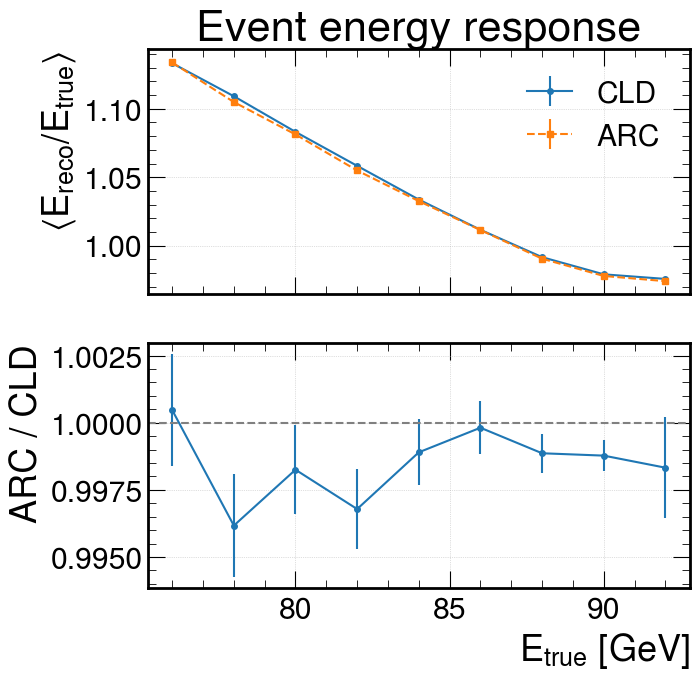

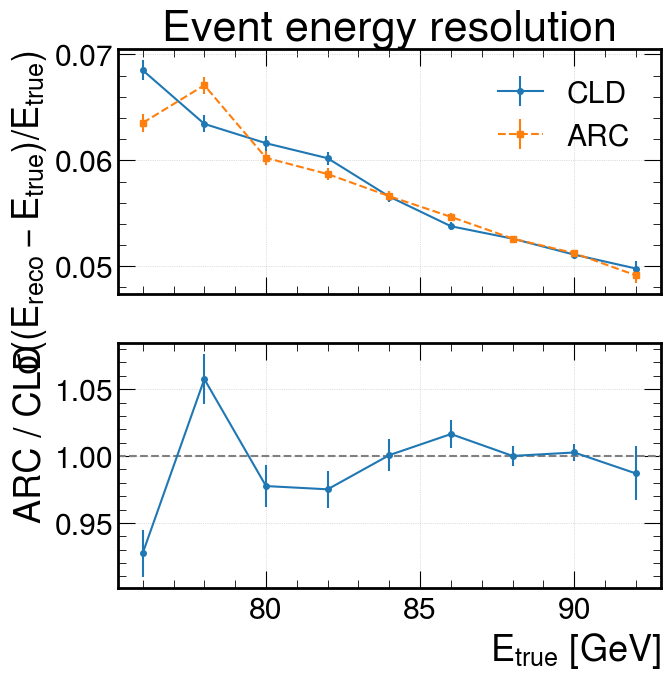

<Figure size 1000x1000 with 0 Axes>

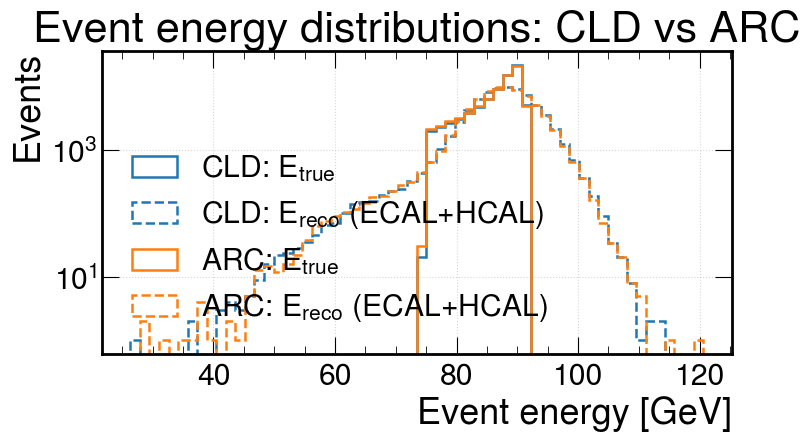

<Figure size 1000x1000 with 0 Axes>

In [23]:
plot_event_energy_response(
    res_E_cld,
    res_E_arc,
)

plot_event_energy_resolution(
    res_E_cld,
    res_E_arc,
)
# Beispiel: aus deiner compute_event_energy_resolution-Funktion
plot_true_vs_reco_hist(
    res_E_cld["E_true_events"],
    res_E_cld["E_reco_events"],
    res_E_arc["E_true_events"],
    res_E_arc["E_reco_events"]
)


In [ ]:
E_true_cld, E_reco_cld = collect_true_and_reco_energy(
    ARC_DIR,
    n_files=200,
    allowed_subdets=[1,2]  # ECAL+HCAL
)

plot_true_vs_reco_hist(E_true_cld, E_reco_cld, component_label="ECAL+HCAL")

TypeError: plot_true_vs_reco_hist() got an unexpected keyword argument 'detector_label'

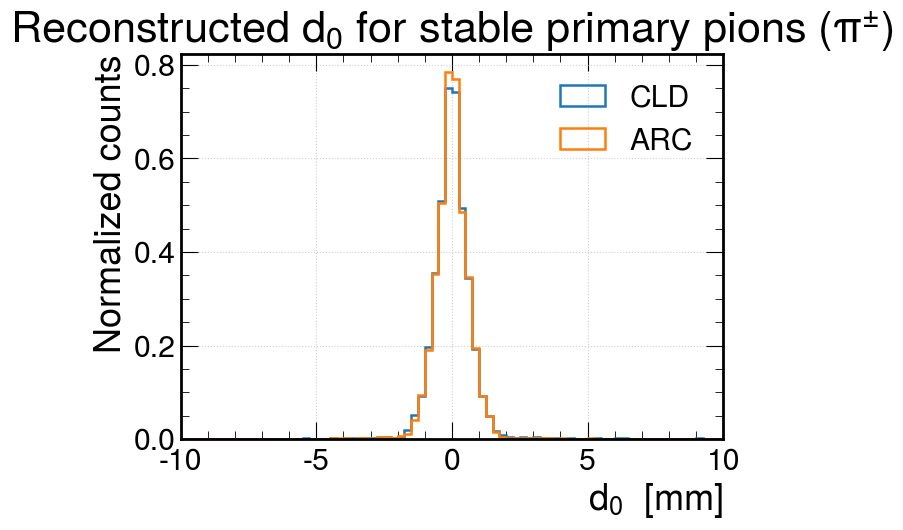

In [25]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import glob

# indices
GEN_PDG_IDX    = 0
GEN_STATUS_IDX = 1
GEN_CHARGE_IDX = 2
GEN_VX_IDX     = 15
GEN_VY_IDX     = 16
GEN_VZ_IDX     = 17
TRK_D0_IDX     = 18

def load_d0_pions(parquet_dir, n_files=50):
    files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))[:n_files]
    d0_list = []

    for fn in files:
        data = ak.from_parquet(fn)

        X_gen      = data["X_gen"]
        X_track    = data["X_track"]
        ygen_track = data["ygen_track"]

        for gen_ev, trk_ev, y_ev in zip(X_gen, X_track, ygen_track):

            gen = np.asarray(gen_ev)
            trk = np.asarray(trk_ev)
            y   = np.asarray(y_ev)

            if gen.size == 0 or trk.size == 0:
                continue

            # --- GEN selection ---
            pdg    = gen[:, GEN_PDG_IDX]
            status = gen[:, GEN_STATUS_IDX]
            charge = gen[:, GEN_CHARGE_IDX]

            vx = gen[:, GEN_VX_IDX]
            vy = gen[:, GEN_VY_IDX]
            vz = gen[:, GEN_VZ_IDX]
            r  = np.sqrt(vx**2 + vy**2)

            is_primary = (status == 1) & (r < 50) & (np.abs(vz) < 50)

            is_pion = np.abs(pdg) == 211
            is_charged = np.abs(charge) > 0

            mask_gen = is_primary & is_pion & is_charged

            if not np.any(mask_gen):
                continue

            # --- matched tracks ---
            y_valid = (y >= 0) & (y < len(gen))
            matched_gen = y[y_valid]
            matched_trk = trk[y_valid]

            # keep only tracks matched to selected pions
            pion_mask = mask_gen[matched_gen]
            d0_vals = matched_trk[pion_mask, TRK_D0_IDX]

            if d0_vals.size > 0:
                d0_list.append(d0_vals)

    if len(d0_list) == 0:
        return np.array([])
    return np.concatenate(d0_list)


# --- load both geometries ---
CLD_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"
ARC_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/arc"

d0_cld = load_d0_pions(CLD_DIR)
d0_arc = load_d0_pions(ARC_DIR)

# --- plot ---
plt.figure(figsize=(7,5))

plt.hist(d0_cld, bins=80, range=(-10, 10),
         histtype="step", linewidth=1.8, label="CLD", density=True)
plt.hist(d0_arc, bins=80, range=(-10, 10),
         histtype="step", linewidth=1.8, label="ARC", density=True)

plt.xlim(-10, 10)
plt.xlabel(r"$d_0$  [mm]")
plt.ylabel("Normalized counts")
plt.title("Reconstructed $d_0$ for stable primary pions ($\\pi^{\\pm}$)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()

plt.show()


In [ ]:
import glob
import numpy as np
import awkward as ak

# indices (as before)
GEN_PDG_IDX    = 0
GEN_STATUS_IDX = 1
GEN_E_IDX      = 8

HIT_E_IDX      = HIT_E_IDX        # already defined earlier
HIT_SUBDET_IDX = HIT_SUBDET_IDX   # already defined earlier


def compute_particle_energy_response_binned(
    parquet_dir,
    n_files=100,
    pdg_filter=(22,),         # tuple/list of PDG codes, e.g. (22,) for photons
    allowed_subdets=None,     # e.g. [1,2] = ECAL+HCAL
    bin_width=5.0,
    min_entries_fit=40,
    E_true_bins=None,         # if None: auto from sample
):
    """
    Particle-level calorimeter response & resolution in E_true bins
    for a given PDG selection.

    For each stable GEN particle with PDG in pdg_filter:
      - E_true = generator energy of that particle
      - E_reco = sum of hit energies assigned to this particle (via ygen_hit),
                 optionally restricted to specific subdetectors.

    We then bin by E_true and extract:
      - mean response <E_reco/E_true>
      - resolution sigma( (E_reco - E_true)/E_true ) from a Gaussian fit.
    """

    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))
    files = parquet_files[:n_files]

    # ---------- 1) Collect particle-level E_true for binning ----------
    E_true_list = []

    for fn in files:
        data = ak.from_parquet(fn)
        X_gen = data["X_gen"]

        for gen_ev in X_gen:
            gen = np.asarray(gen_ev)
            if gen.size == 0:
                continue

            status = gen[:, GEN_STATUS_IDX]
            pdg    = gen[:, GEN_PDG_IDX]

            is_sel = (status == 1) & np.isin(pdg, pdg_filter)

            if not np.any(is_sel):
                continue

            E_true_particles = gen[is_sel, GEN_E_IDX]
            E_true_list.extend(E_true_particles[E_true_particles > 0.0])

    if len(E_true_list) == 0:
        raise RuntimeError("No particles matching selection for binning.")

    E_true_arr = np.array(E_true_list)

    # ---------- 2) Define binning ----------
    if E_true_bins is None:
        E_min = np.min(E_true_arr)
        #E_max = np.max(E_true_arr)
        E_max = (10.0)
        n_bins = int(np.ceil((E_max - E_min) / bin_width))
        E_true_bins = E_min + np.arange(n_bins + 1) * bin_width
    else:
        E_true_bins = np.asarray(E_true_bins, float)
        if E_true_bins.ndim != 1 or E_true_bins.size < 2:
            raise ValueError("E_true_bins must be 1D array with >= 2 edges.")

    E_min = E_true_bins[0]
    E_max = E_true_bins[-1]
    n_bins = len(E_true_bins) - 1
    E_centers = 0.5 * (E_true_bins[:-1] + E_true_bins[1:])

    residuals_bins = [[] for _ in range(n_bins)]

    # also store raw per-particle values if you want later plots
    E_true_particles_all = []
    E_reco_particles_all = []

    # ---------- 3) Loop again: compute E_reco per particle ----------
    for fn in files:
        data = ak.from_parquet(fn)

        X_gen      = data["X_gen"]
        X_hit      = data["X_hit"]
        ygen_hit   = data["ygen_hit"]   # hit -> gen index

        for gen_ev, hits_ev, yhit_ev in zip(X_gen, X_hit, ygen_hit):

            gen  = np.asarray(gen_ev)
            hits = np.asarray(hits_ev)
            yhit = np.asarray(yhit_ev)

            n_gen = len(gen)
            if n_gen == 0 or len(hits) == 0:
                continue

            status = gen[:, GEN_STATUS_IDX]
            pdg    = gen[:, GEN_PDG_IDX]

            is_sel = (status == 1) & np.isin(pdg, pdg_filter)
            if not np.any(is_sel):
                continue

            # --- build per-gen E_reco via bincount ---
            valid = (yhit >= 0) & (yhit < n_gen)
            if not np.any(valid):
                continue

            if allowed_subdets is not None:
                subdet = hits[:, HIT_SUBDET_IDX].astype(int)
                valid &= np.isin(subdet, allowed_subdets)

            if not np.any(valid):
                continue

            gidx = yhit[valid].astype(int)
            Ehit = hits[valid, HIT_E_IDX]

            E_reco_per_gen = np.bincount(
                gidx, weights=Ehit, minlength=n_gen
            )

            # restrict to selected PDG + stable
            E_true_sel = gen[is_sel, GEN_E_IDX]
            E_reco_sel = E_reco_per_gen[is_sel]

            # keep only particles inside [E_min, E_max]
            mask_energy = (E_true_sel > 0.0) & (E_true_sel >= E_min) & (E_true_sel <= E_max)
            if not np.any(mask_energy):
                continue

            E_true_sel = E_true_sel[mask_energy]
            E_reco_sel = E_reco_sel[mask_energy]

            # store raw per-particle values
            E_true_particles_all.extend(E_true_sel)
            E_reco_particles_all.extend(E_reco_sel)

            # residuals R = (E_reco - E_true)/E_true
            R = (E_reco_sel - E_true_sel) / E_true_sel

            idx = np.digitize(E_true_sel, E_true_bins) - 1
            for k, r in zip(idx, R):
                if 0 <= k < n_bins:
                    residuals_bins[k].append(r)

    # ---------- 4) Fit per bin + response stats ----------
    sigma      = np.full(n_bins, np.nan)
    mu         = np.full(n_bins, np.nan)
    n_entries  = np.zeros(n_bins, int)
    mean_ratio = np.full(n_bins, np.nan)
    mean_ratio_err = np.full(n_bins, np.nan)

    for i in range(n_bins):
        res_list = np.asarray(residuals_bins[i], float)
        n = res_list.size
        n_entries[i] = n
        if n == 0:
            continue

        mean_R = np.mean(res_list)
        std_R  = np.std(res_list, ddof=1) if n > 1 else 0.0

        # mean(E_reco/E_true)
        mean_ratio[i] = 1.0 + mean_R
        mean_ratio_err[i] = std_R / np.sqrt(n) if n > 1 else np.nan

        if n < min_entries_fit:
            continue

        sig, mean = _fit_gaussian_3sigma_clipped_fast(
            res_list, min_entries=min_entries_fit
        )
        sigma[i] = sig
        mu[i] = mean

    mean_ratio_percent = 100.0 * mean_ratio
    mean_ratio_percent_err = 100.0 * mean_ratio_err

    return {
        "E_true_bins": E_true_bins,
        "E_true_centers": E_centers,
        "sigma": sigma,
        "mu": mu,
        "n_entries": n_entries,
        "bin_width": bin_width,
        "residual_mode": "R = (E_reco - E_true) / E_true",
        "mean_ratio": mean_ratio,
        "mean_ratio_err": mean_ratio_err,
        "mean_ratio_percent": mean_ratio_percent,
        "mean_ratio_percent_err": mean_ratio_percent_err,
        "E_true_particles": np.array(E_true_particles_all),
        "E_reco_particles": np.array(E_reco_particles_all),
    }


In [27]:
def plot_particle_energy_resolution(res_cld, res_arc, title="Particle energy resolution", pdg=None):
    E = res_cld["E_true_centers"]

    s_cld = res_cld["sigma"]
    s_arc = res_arc["sigma"]

    n_cld = res_cld["n_entries"]
    n_arc = res_arc["n_entries"]

    s_cld_err = s_cld / np.sqrt(2 * np.maximum(n_cld - 1, 1))
    s_arc_err = s_arc / np.sqrt(2 * np.maximum(n_arc - 1, 1))

    ratio = s_arc / s_cld
    rel_cld = s_cld_err / s_cld
    rel_arc = s_arc_err / s_arc
    ratio_err = ratio * np.sqrt(rel_cld**2 + rel_arc**2)

    fig = plt.figure(figsize=(7, 7))

    ax1 = fig.add_subplot(211)
    ax1.errorbar(E, s_cld, yerr=s_cld_err, fmt="o-", ms=4, label="CLD")
    ax1.errorbar(E, s_arc, yerr=s_arc_err, fmt="s--", ms=4, label="ARC")
    ax1.set_ylabel(r"$\sigma((E_{\mathrm{reco}} - E_{\mathrm{true}})/E_{\mathrm{true}})$")
    ax1.set_title(title)
    ax1.grid(True, linestyle=":", linewidth=0.5)
    ax1.legend()
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.errorbar(E, ratio, yerr=ratio_err, fmt="o-", ms=4)
    ax2.axhline(1.0, linestyle="--", color="gray")
    ax2.set_xlabel(r"$E_{\mathrm{true}}$ [GeV]")
    ax2.set_ylabel("ARC / CLD")
    ax2.grid(True, linestyle=":", linewidth=0.5)

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{PLOT_DIR}/particle_energy_resolution_{pdg}.png")


In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_energy_response(res_cld, res_arc, title="Particle energy response", pdg=None):
    E = res_cld["E_true_centers"]

    # mean response = <Ereco/Etrue>
    r_cld = res_cld["mean_ratio"]
    r_arc = res_arc["mean_ratio"]

    r_cld_err = res_cld["mean_ratio_err"]
    r_arc_err = res_arc["mean_ratio_err"]

    # ratio ARC/CLD
    ratio = r_arc / r_cld
    ratio_err = ratio * np.sqrt((r_cld_err/r_cld)**2 + (r_arc_err/r_arc)**2)

    fig = plt.figure(figsize=(7,7))

    # --- upper panel ---
    ax1 = fig.add_subplot(211)
    ax1.errorbar(E, r_cld, yerr=r_cld_err, fmt="o-", markersize=4, label="CLD")
    ax1.errorbar(E, r_arc, yerr=r_arc_err, fmt="s--", markersize=4, label="ARC")

    ax1.set_ylabel(r"$E_{\mathrm{reco}} / E_{\mathrm{true}}$")
    ax1.set_title(title)
    ax1.grid(True, linestyle=":", linewidth=0.5)
    ax1.legend()
    plt.setp(ax1.get_xticklabels(), visible=False)

    # --- lower panel ---
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.errorbar(E, ratio, yerr=ratio_err, fmt="o-", markersize=4)
    ax2.axhline(1.0, linestyle="--", color="gray")
    ax2.set_xlabel(r"$E_{\mathrm{true}}$ [GeV]")
    ax2.set_ylabel("ARC / CLD")
    ax2.grid(True, linestyle=":", linewidth=0.5)

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{PLOT_DIR}/particle_energy_response_{pdg}.png")


In [44]:
CLD_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"
ARC_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/arc"

# photons
res_gamma_cld = compute_particle_energy_response_binned(
    CLD_DIR,
    n_files=500,
    pdg_filter=(22,),
    allowed_subdets=[1, 2],    # ECAL+HCAL (or ECAL-only)
    bin_width=1.0,
    min_entries_fit=500,
)

res_gamma_arc = compute_particle_energy_response_binned(
    ARC_DIR,
    n_files=500,
    pdg_filter=(22,),
    allowed_subdets=[1, 2],
    bin_width=1.0,
    min_entries_fit=500,
    E_true_bins=res_gamma_cld["E_true_bins"],   # same bins
)

# charged pions
res_pi_cld = compute_particle_energy_response_binned(
    CLD_DIR,
    n_files=500,
    pdg_filter=(211, -211),
    allowed_subdets=[1, 2],
    bin_width=1.0,
    min_entries_fit=500,
)

res_pi_arc = compute_particle_energy_response_binned(
    ARC_DIR,
    n_files=500,
    pdg_filter=(211, -211),
    allowed_subdets=[1, 2],
    bin_width=1.0,
    min_entries_fit=500,
    E_true_bins=res_pi_cld["E_true_bins"],
)

# K0_L
res_KL_cld = compute_particle_energy_response_binned(
    CLD_DIR,
    n_files=500,
    pdg_filter=(130,),
    allowed_subdets=[1, 2],
    bin_width=1.0,
    min_entries_fit=40,
)
res_KL_arc = compute_particle_energy_response_binned(
    ARC_DIR,
    n_files=500,
    pdg_filter=(130,),
    allowed_subdets=[1, 2],
    bin_width=1.0,
    min_entries_fit=40,
    E_true_bins=res_KL_cld["E_true_bins"],
)

# neutrons & antineutrons
res_n_cld = compute_particle_energy_response_binned(
    CLD_DIR,
    n_files=500,
    pdg_filter=(2112, -2112),
    allowed_subdets=[1, 2],
    bin_width=1.0,
    min_entries_fit=40,
)
res_n_arc = compute_particle_energy_response_binned(
    ARC_DIR,
    n_files=500,
    pdg_filter=(2112, -2112),
    allowed_subdets=[1, 2],
    bin_width=1.0,
    min_entries_fit=40,
    E_true_bins=res_n_cld["E_true_bins"],
)


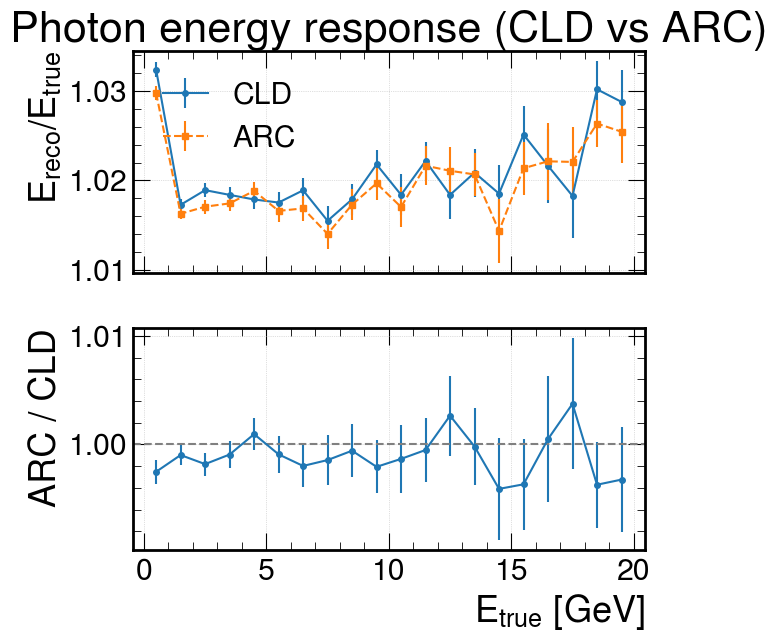

<Figure size 1000x1000 with 0 Axes>

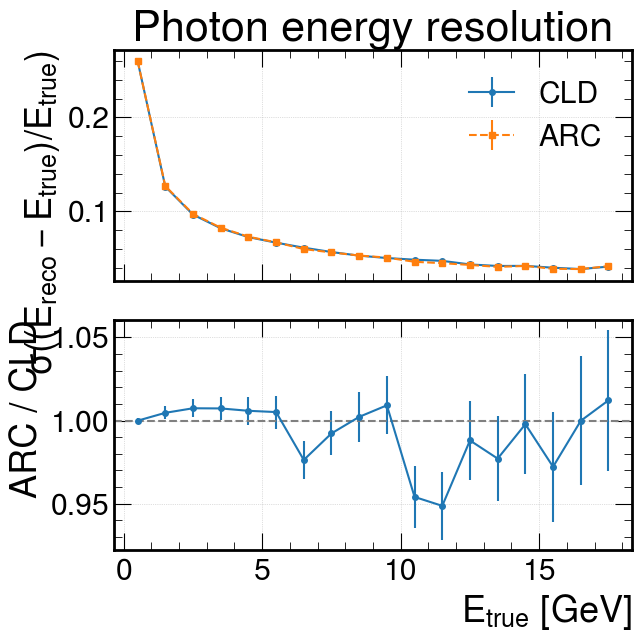

<Figure size 1000x1000 with 0 Axes>

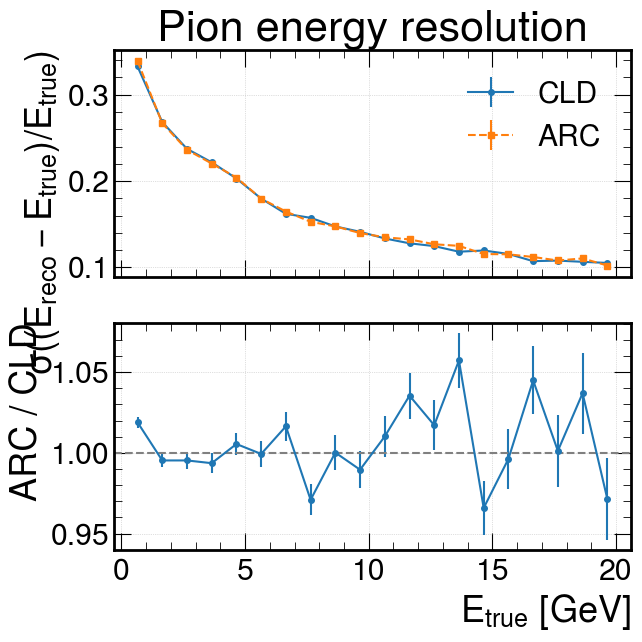

<Figure size 1000x1000 with 0 Axes>

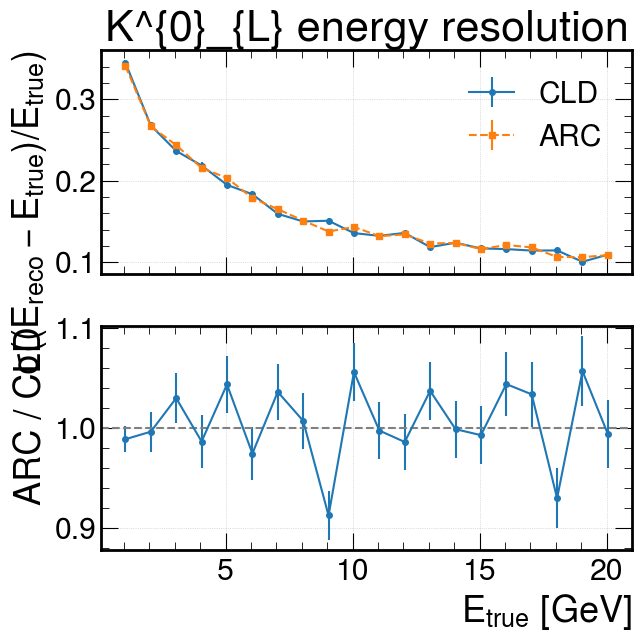

<Figure size 1000x1000 with 0 Axes>

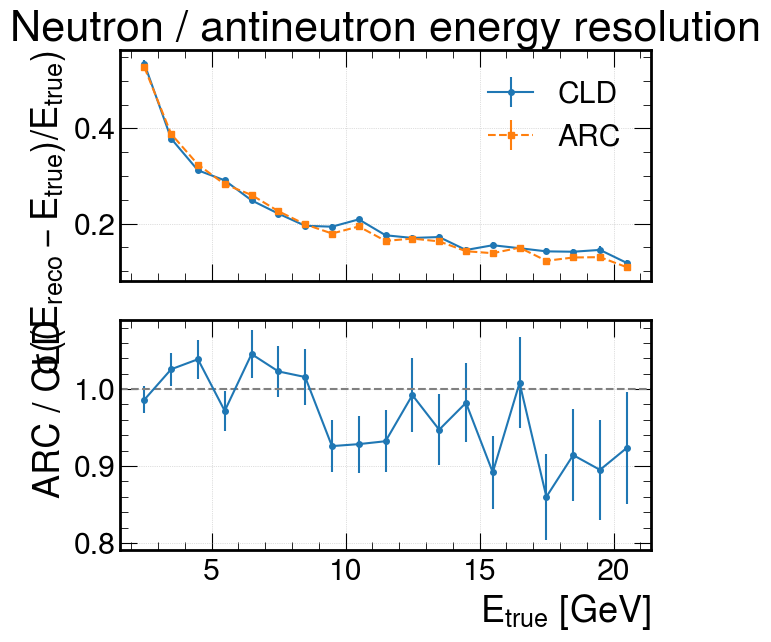

<Figure size 1000x1000 with 0 Axes>

In [45]:
plot_particle_energy_response(
    res_gamma_cld,
    res_gamma_arc,
    title="Photon energy response (CLD vs ARC)",
    pdg="gamma"
)


plot_particle_energy_resolution(res_gamma_cld, res_gamma_arc,
                                title="Photon energy resolution", pdg="gamma")
plot_particle_energy_resolution(res_pi_cld, res_pi_arc,
                                title="Pion energy resolution", pdg="pi")
plot_particle_energy_resolution(res_KL_cld, res_KL_arc,
                                title="K^{0}_{L} energy resolution", pdg="KL")
plot_particle_energy_resolution(res_n_cld, res_n_arc,
                                title="Neutron / antineutron energy resolution", pdg="n")

In [31]:
import glob
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

def collect_particle_Ereco_over_Etrue(
    parquet_dir,
    n_files=100,
    pdg_filter=(22,),          # z.B. (22,) für Photonen, (211,-211) für π±
    allowed_subdets=None,      # z.B. [1,2] = ECAL+HCAL
    E_true_min=None,
    E_true_max=None,
):
    """
    Liefert ein 1D-Array mit Ereco/Etrue für alle GEN-Teilchen,
    die
      - status==1,
      - PDG in pdg_filter,
      - E_true im [E_true_min, E_true_max] (falls gesetzt)
    und deren Hits (via ygen_hit) in allowed_subdets liegen (falls gesetzt).
    """

    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))[:n_files]

    ratios = []

    for fn in parquet_files:
        data = ak.from_parquet(fn)

        X_gen    = data["X_gen"]
        X_hit    = data["X_hit"]
        ygen_hit = data["ygen_hit"]   # hit -> gen index

        for gen_ev, hits_ev, yhit_ev in zip(X_gen, X_hit, ygen_hit):

            gen  = np.asarray(gen_ev)
            hits = np.asarray(hits_ev)
            yhit = np.asarray(yhit_ev)

            n_gen = len(gen)
            if n_gen == 0 or len(hits) == 0:
                continue

            status = gen[:, GEN_STATUS_IDX]
            pdg    = gen[:, GEN_PDG_IDX]

            # stabile GEN-Teilchen des gewünschten Typs
            is_sel = (status == 1) & np.isin(pdg, pdg_filter)
            if not np.any(is_sel):
                continue

            # gültige Hits (mit Zuordnung zu GEN-Partikeln)
            valid = (yhit >= 0) & (yhit < n_gen)
            if not np.any(valid):
                continue

            if allowed_subdets is not None:
                subdet = hits[:, HIT_SUBDET_IDX].astype(int)
                valid &= np.isin(subdet, allowed_subdets)

            if not np.any(valid):
                continue

            gidx = yhit[valid].astype(int)
            Ehit = hits[valid, HIT_E_IDX]

            # pro GEN-Teilchen aufsummierte Ereco via bincount
            E_reco_per_gen = np.bincount(
                gidx, weights=Ehit, minlength=n_gen
            )

            # nur selektierte GEN-Teilchen
            E_true_sel = gen[is_sel, GEN_E_IDX]
            E_reco_sel = E_reco_per_gen[is_sel]

            # E-Range anwenden
            mask_E = (E_true_sel > 0.0)
            if E_true_min is not None:
                mask_E &= (E_true_sel >= E_true_min)
            if E_true_max is not None:
                mask_E &= (E_true_sel <  E_true_max)

            if not np.any(mask_E):
                continue

            E_true_sel = E_true_sel[mask_E]
            E_reco_sel = E_reco_sel[mask_E]

            ratios.extend(E_reco_sel / E_true_sel)

    return np.array(ratios, dtype=float)


In [74]:
from math import sqrt, pi
from scipy.optimize import curve_fit

def _gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def fit_gauss_residuals(residuals, min_entries=40):
    residuals = np.asarray(residuals, dtype=float)
    n = residuals.size
    if n < min_entries:
        return np.nan, np.nan

    # robuste Startschätzung
    m0 = np.median(residuals)
    q16, q84 = np.percentile(residuals, [16, 84])
    sig0 = 0.5 * (q84 - q16)
    if not np.isfinite(sig0) or sig0 <= 0:
        return np.nan, np.nan

    # 3σ-Clipping um 0 (wie in deiner Resolution-Funktion)
    mask = np.abs(residuals - 0.0) < 3.0 * sig0
    res_clipped = residuals[mask]
    if res_clipped.size < min_entries:
        res_clipped = residuals  # Fallback

    # Histogram für den Fit
    counts, edges = np.histogram(res_clipped, bins="auto")
    xcenters = 0.5 * (edges[:-1] + edges[1:])
    mnonzero = counts > 0
    x_fit = xcenters[mnonzero]
    y_fit = counts[mnonzero]

    if x_fit.size < 5:
        return np.nan, np.nan

    A0 = y_fit.max()
    mu0 = 0.0
    sig0 = np.std(res_clipped)
    if not np.isfinite(sig0) or sig0 <= 0:
        return np.nan, np.nan

    try:
        popt, _ = curve_fit(_gauss, x_fit, y_fit, p0=[A0, mu0, sig0], maxfev=5000)
        A_fit, mu_fit, sig_fit = popt
        if not np.isfinite(sig_fit) or sig_fit <= 0:
            return np.nan, np.nan
        return mu_fit, sig_fit
    except Exception:
        return np.nan, np.nan


In [78]:
def add_gauss_fit_to_ratio(data_ratio, color, label, ax, bins, x_min, x_max):
    # Residuen: R = ratio - 1
    R = data_ratio - 1.0

    mu_R, sigma_R = fit_gauss_residuals(R, min_entries=40)
    if not np.isfinite(mu_R) or not np.isfinite(sigma_R) or sigma_R <= 0:
        return

    # Histogram der Ratios (genau wie im Hauptplot)
    hist_vals, hist_edges = np.histogram(
        data_ratio, bins=bins, range=(x_min, x_max), density=True
    )

    # x in Residuen-space (R)
    R_grid = np.linspace(mu_R - 4*sigma_R, mu_R + 4*sigma_R, 400)
    # Gauß in Residuen-space (noch unskaliert in der Höhe, aber normiert auf integral 1)
    gauss_R = (1.0 / (sigma_R * np.sqrt(2*np.pi))) * np.exp(-0.5*((R_grid - mu_R)/sigma_R)**2)

    # Wir wollen die Form, aber Höhe an Histogramm anpassen:
    # Histogramm ist density=True → Integral = 1 über ganzen support,
    # aber wir skalieren einfach auf das Maximum (visuell schöner):
    if np.any(hist_vals > 0):
        scale = hist_vals.max() / gauss_R.max()
    else:
        scale = 1.0
    gauss_R *= scale

    # zurück in ratio-Space: ratio = 1 + R
    ratio_grid = 1.0 + R_grid

    ax.plot(
        ratio_grid, gauss_R,
        color=color,
        linestyle="-",
        alpha=0.7,
        label=f"{label} Gaussian (μ={1+mu_R:.3f}, σ={sigma_R:.3f})",
    )


In [76]:
def plot_particle_response_hist_CLD_ARC(
    CLD_DIR,
    ARC_DIR,
    pdg_filter=(22,),
    pdg_label=r"\gamma",
    allowed_subdets=None,
    E_true_min=20.0,
    E_true_max=25.0,
    n_files=100,
    bins=100,
):
    # Daten laden
    ratios_cld = collect_particle_Ereco_over_Etrue(
        CLD_DIR, n_files=n_files, pdg_filter=pdg_filter,
        allowed_subdets=allowed_subdets,
        E_true_min=E_true_min, E_true_max=E_true_max,
    )
    ratios_arc = collect_particle_Ereco_over_Etrue(
        ARC_DIR, n_files=n_files, pdg_filter=pdg_filter,
        allowed_subdets=allowed_subdets,
        E_true_min=E_true_min, E_true_max=E_true_max,
    )

    print(f"CLD: {len(ratios_cld)} Teilchen im Bin, ARC: {len(ratios_arc)}")

    if len(ratios_cld) == 0 or len(ratios_arc) == 0:
        print("Zu wenige Einträge in diesem E_true-Bereich.")
        return

    # Bereich fest auf [0,4] begrenzen (wie du wolltest)
    x_min, x_max = 0.0, 4.0

    fig, ax = plt.subplots(figsize=(7,5))

    # Histogramme
    ax.hist(
        ratios_cld,
        bins=bins,
        range=(x_min, x_max),
        histtype="step",
        density=True,
        linewidth=1.8,
        label=f"CLD, {pdg_label}",
    )
    ax.hist(
        ratios_arc,
        bins=bins,
        range=(x_min, x_max),
        histtype="step",
        density=True,
        linewidth=1.8,
        linestyle="--",
        label=f"ARC, {pdg_label}",
    )

    # Gauss-Fits (robust, konsistent mit Resolution-Definition)
    add_gauss_fit_to_ratio(ratios_cld, "C0", "CLD", ax, bins, x_min, x_max)
    add_gauss_fit_to_ratio(ratios_arc, "C1", "ARC", ax, bins, x_min, x_max)

    ax.set_xlabel(r"$E_{\mathrm{reco}} / E_{\mathrm{true}}$")
    ax.set_ylabel("Normalized events")
    ax.set_title(
        rf"{pdg_label}: $E_{{\mathrm{{true}}}} \in [{E_true_min:.1f},{E_true_max:.1f}]$ GeV"
    )
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend(loc="upper right", fontsize=9, framealpha=0.8)

    plt.tight_layout()
    plt.show()
    plt.savefig(
        f"{PLOT_DIR}/particle_response_hist_{pdg_label}_"
        f"{E_true_min:.0f}_{E_true_max:.0f}.png",
        dpi=200
    )


CLD: 211617 Teilchen im Bin, ARC: 211517


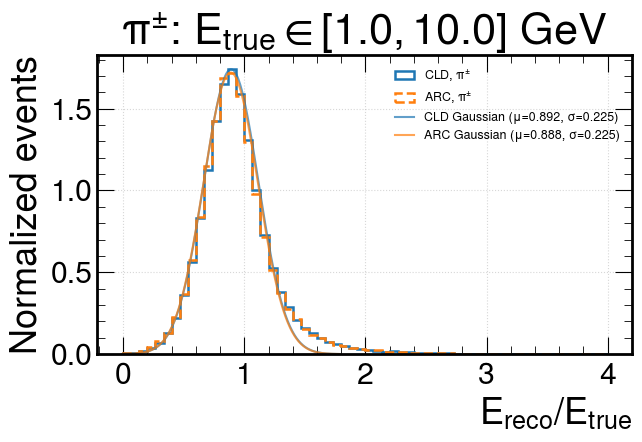

CLD: 164099 Teilchen im Bin, ARC: 162923


<Figure size 1000x1000 with 0 Axes>

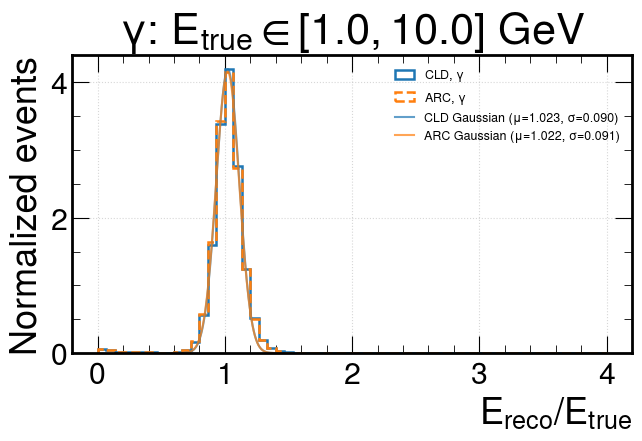

CLD: 18896 Teilchen im Bin, ARC: 18936


<Figure size 1000x1000 with 0 Axes>

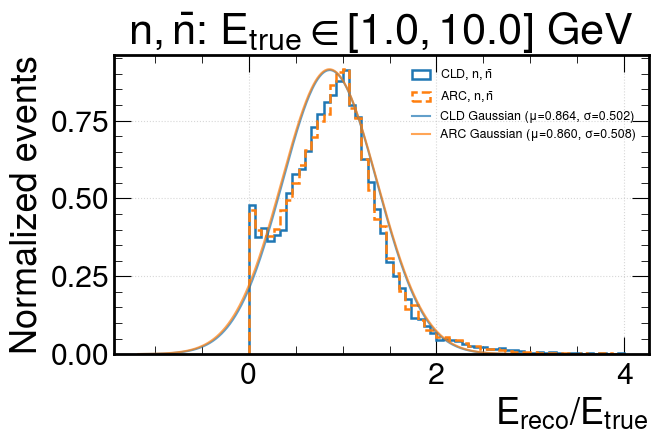

CLD: 15391 Teilchen im Bin, ARC: 15343


<Figure size 1000x1000 with 0 Axes>

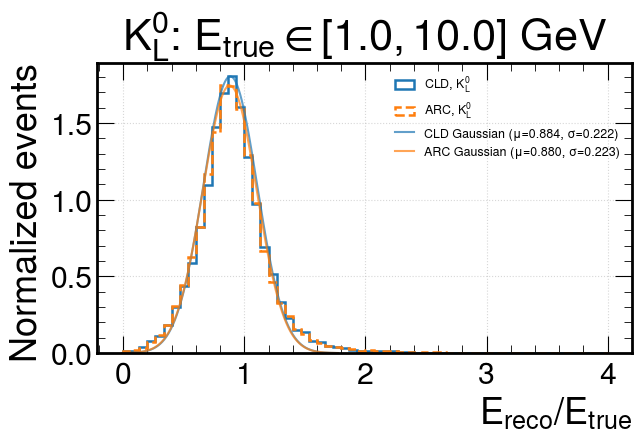

<Figure size 1000x1000 with 0 Axes>

In [79]:
plot_particle_response_hist_CLD_ARC(
    CLD_DIR,
    ARC_DIR,
    pdg_filter=(211, -211),
    pdg_label=r"$\pi^{\pm}$",
    allowed_subdets=[1,2],
    E_true_min=1.0,
    E_true_max=10.0,
    n_files=500,
    bins=60,
)
plot_particle_response_hist_CLD_ARC(
    CLD_DIR,
    ARC_DIR,
    pdg_filter=(22,),
    pdg_label=r"$\gamma$",
    allowed_subdets=[1,2],    # ECAL+HCAL, wie oben
    E_true_min=1.0,
    E_true_max=10.0,
    n_files=500,
    bins=60,
)

plot_particle_response_hist_CLD_ARC(
    CLD_DIR,
    ARC_DIR,
    pdg_filter=(2112, -2112),
    pdg_label=r"$n, \bar{n}$",
    allowed_subdets=[1,2],    # ECAL+HCAL, wie oben
    E_true_min=1.0,
    E_true_max=10.0,
    n_files=500,
    bins=60,
)
plot_particle_response_hist_CLD_ARC(
    CLD_DIR,
    ARC_DIR,
    pdg_filter=(130,),
    pdg_label=r"$K^0_L$",
    allowed_subdets=[1,2],    # ECAL+HCAL, wie oben
    E_true_min=1.0,
    E_true_max=10.0,
    n_files=500,
    bins=60,
)


